# ICP-OES Spektral İşleme (MVP, Optimize Edilmiş)

Bu defter kobalt (Co) 228.615 nm hattı örneği üzerinden aşağıdaki adımları yalın ve hızlı bir şekilde uygular:

- Veri keşfi ve yükleme
- Arka plan çıkarma (background subtraction)
- İnterpolasyonla veri noktası artırma
- Savitzky–Golay ile yumuşatma (smoothing)
- Pik tespiti ve kalibrasyon eğrisi
- İşlenmiş pik ile ham tepe arasındaki farkların (Δλ, ΔI) hesaplanması

Her bölümün üstünde kısa açıklamalar bulunmaktadır. Varsayılan ayarlar Python 3.9 uyumlu olacak şekilde düzenlenmiştir.


In [1]:
# ------------------------------
# 0) Kütüphaneler
# ------------------------------
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate as interp
from scipy.signal import savgol_filter, find_peaks

# Plot ayarları
plt.rcParams["figure.dpi"] = 120


## 1) Veri Yolu ve Dosya Keşfi

Co verileri `../ICP_OES_Fitting_Data/Co` klasöründedir. Dosyaları konsantrasyona göre sıralarız ve temel bilgiler yazdırılır.


In [2]:
# ------------------------------
# 1) Veri yolu ve dosyaların keşfi
# ------------------------------

data_path = "../ICP_OES_Fitting_Data/Co"
co_files = glob.glob(os.path.join(data_path, "Co*.csv"))

assert len(co_files) > 0, "Co CSV dosyaları bulunamadı. data_path'i kontrol edin."

def extract_concentration(filename: str) -> float:
	base = os.path.basename(filename)
	conc_str = base.split('--')[1].split(' ppm')[0]
	return float(conc_str)

# Konsantrasyona göre sırala
co_files.sort(key=extract_concentration)

concentrations = [extract_concentration(f) for f in co_files]
print("Sıralı konsantrasyonlar (ppm):", concentrations)
print("Dosya sayısı:", len(co_files))

# Dalgaboyu bilgisini türet
sample_fn = os.path.basename(co_files[0])
wavel_info = sample_fn.split('(')[1].split(')')[0]
wavelength_nm = wavel_info.replace('n', '')
print(f"Analiz dalgaboyu: {wavelength_nm} nm")


Sıralı konsantrasyonlar (ppm): [0.0, 1.0, 5.0, 10.0, 20.0, 50.0, 100.0]
Dosya sayısı: 7
Analiz dalgaboyu: 228615 nm


## 2) Veri Okuma

CSV formatı `Wavelength`, `Background`, `Spectrum` sütunları içerir. `Spectrum_Original` değiştirilmeyecek referans olarak eklenir.


In [3]:
# ------------------------------
# 2) Veri okuma fonksiyonu
# ------------------------------

def read_co_data(file_path: str) -> pd.DataFrame:
	df = pd.read_csv(file_path, skiprows=1)
	df.columns = ['Wavelength', 'Background', 'Spectrum']
	# sayısallaştır ve boşları temizle
	df['Wavelength'] = pd.to_numeric(df['Wavelength'], errors='coerce')
	df['Background'] = pd.to_numeric(df['Background'], errors='coerce')
	df['Spectrum'] = pd.to_numeric(df['Spectrum'], errors='coerce')
	df = df.dropna(subset=['Wavelength', 'Spectrum'])
	# referans kopya
	df['Spectrum_Original'] = df['Spectrum'].copy()
	return df


## 3) Tüm Verileri Yükleme

Tüm dosyalar okunur ve `co_data` sözlüğüne konsantrasyon anahtarıyla eklenir.


In [4]:
# ------------------------------
# 3) Verileri yükle
# ------------------------------

co_data: dict[float, pd.DataFrame] = {}
for f in co_files:
	conc = extract_concentration(f)
	df = read_co_data(f)
	co_data[conc] = df
	print(f"{conc:5.1f} ppm -> {len(df)} satır")

print("Toplam konsantrasyon:", len(co_data))
print("0 ppm örnek ilk 5 satır:\n", co_data[min(co_data.keys())].head())


  0.0 ppm -> 47 satır
  1.0 ppm -> 47 satır
  5.0 ppm -> 47 satır
 10.0 ppm -> 47 satır
 20.0 ppm -> 47 satır
 50.0 ppm -> 47 satır
100.0 ppm -> 47 satır
Toplam konsantrasyon: 7
0 ppm örnek ilk 5 satır:
    Wavelength  Background  Spectrum  Spectrum_Original
0     228.585     363.854   359.895            359.895
1     228.586     356.074   357.025            357.025
2     228.587     349.298   352.456            352.456
3     228.589     343.526   346.416            346.416
4     228.590     338.710   339.976            339.976


## 4) Arka Plan Çıkarma, 5) İnterpolasyon, 6) Yumuşatma

Aşağıdaki fonksiyonlar tek tek çalışır. Ardından `process_spectral_data` hepsini pipeline olarak uygular.


In [5]:
# ------------------------------
# 4) Arka plan çıkarma
# ------------------------------

def perform_background_subtraction(df: pd.DataFrame) -> pd.DataFrame:
	out = df.copy()
	out['Corrected_Spectrum'] = out['Spectrum'] - out['Background']
	# güvenlik: referans kalsın
	if 'Spectrum_Original' not in out.columns:
		out['Spectrum_Original'] = df['Spectrum']
	return out

# ------------------------------
# 5) İnterpolasyon ile veri artırma
# ------------------------------

def increase_data_points(df: pd.DataFrame, factor: int = 10) -> pd.DataFrame:
	x = df['Wavelength'].values
	n_new = len(x) * factor
	x_new = np.linspace(x.min(), x.max(), n_new)

	res = pd.DataFrame({'Wavelength': x_new})

	# Spectrum
	cs_spec = interp.CubicSpline(x, df['Spectrum'].values)
	res['Spectrum'] = cs_spec(x_new)
	res['Interpolated_Spectrum'] = res['Spectrum']

	# Background (varsa)
	if 'Background' in df.columns:
		cs_bg = interp.CubicSpline(x, df['Background'].values)
		res['Interpolated_Background'] = cs_bg(x_new)

	# Corrected (varsa)
	if 'Corrected_Spectrum' in df.columns:
		cs_corr = interp.CubicSpline(x, df['Corrected_Spectrum'].values)
		res['Interpolated_Corrected_Spectrum'] = cs_corr(x_new)

	# Orijinal değerleri attrs'ta sakla, sütunu NaN olarak koru
	res['Spectrum_Original'] = np.nan
	res.attrs['Spectrum_Original'] = df['Spectrum_Original'].values if 'Spectrum_Original' in df.columns else None
	res.attrs['original_wavelength'] = x
	return res

# ------------------------------
# 6) Yumuşatma (Savitzky–Golay) - Güvenli pencere boyutu kontrolü ile
# ------------------------------

def apply_smoothing(df: pd.DataFrame, window_length: int = 51, polyorder: int = 3) -> pd.DataFrame:
	if window_length % 2 == 0:
		window_length += 1
	out = df.copy()
	
	# Güvenli pencere boyutu hesapla
	def _safe_savgol(data_array, wl, po):
		data_size = len(data_array)
		wl_safe = min(wl, data_size - 1) if data_size > 1 else 1
		if wl_safe % 2 == 0:  # Tek sayı olmalı
			wl_safe -= 1
		if wl_safe < 1:
			wl_safe = 1
		
		# Pencere boyutu polyorder'dan büyük olmalı
		if wl_safe <= po:
			return data_array  # Smoothing yapılamaz, orijinal veriyi döndür
		else:
			return savgol_filter(data_array, wl_safe, po)
	
	if 'Interpolated_Corrected_Spectrum' in out.columns:
		out['Smoothed_Corrected_Spectrum'] = _safe_savgol(out['Interpolated_Corrected_Spectrum'].values, window_length, polyorder)
	elif 'Corrected_Spectrum' in out.columns:
		out['Smoothed_Corrected_Spectrum'] = _safe_savgol(out['Corrected_Spectrum'].values, window_length, polyorder)
	if 'Interpolated_Spectrum' in out.columns:
		out['Smoothed_Interpolated_Spectrum'] = _safe_savgol(out['Interpolated_Spectrum'].values, window_length, polyorder)
	elif 'Spectrum' in out.columns:
		out['Smoothed_Spectrum'] = _safe_savgol(out['Spectrum'].values, window_length, polyorder)
	return out

In [6]:
# ------------------------------
# 7) Tam işleme hattı (pipeline)
# ------------------------------

def process_spectral_data(co_data: dict,
						  background_subtract: bool = True,
						  increase_points_flag: bool = True,
						  apply_smooth: bool = True,
						  factor: int = 10,
						  window_length: int = 51,
						  polyorder: int = 3) -> dict:
	processed = {}
	for conc in sorted(co_data.keys()):
		df = co_data[conc]
		cur = df.copy()
		if background_subtract and 'Background' in cur.columns:
			cur = perform_background_subtraction(cur)
		if increase_points_flag:
			cur = increase_data_points(cur, factor=factor)
		if apply_smooth:
			cur = apply_smoothing(cur, window_length=window_length, polyorder=polyorder)
		# referans kolonu garanti et
		if 'Spectrum_Original' not in cur.columns:
			cur['Spectrum_Original'] = np.nan
		processed[conc] = cur
	return processed


## 8) Pik Tespiti, 9) Grafikler

- Tam spektrum ve pik bölgesi çizilir; işlenmiş ve ham veriler birlikte gösterilir.
- Basit pik tespiti için `find_peaks` kullanılır.


In [7]:
def plot_processed_spectra(processed_data: dict,
						   peak_range=(228.610, 228.620),
						   figsize=(18, 8)):
	concs = sorted(processed_data.keys())
	fig, (ax_full, ax_peak) = plt.subplots(1, 2, figsize=figsize)
	# Full
	for c in concs:
		df = processed_data[c]
		if 'Smoothed_Corrected_Spectrum' in df.columns:
			y = df['Smoothed_Corrected_Spectrum']
		elif 'Interpolated_Corrected_Spectrum' in df.columns:
			y = df['Interpolated_Corrected_Spectrum']
		else:
			y = df['Spectrum']
		ax_full.plot(df['Wavelength'], y, label=f"{c:.0f} ppm (processed)")
		if 'Spectrum_Original' in df.attrs:
			raw_y = df.attrs['Spectrum_Original']
			raw_x = df.attrs['original_wavelength']
			ax_full.scatter(raw_x, raw_y, s=10, alpha=0.5, label=f"{c:.0f} ppm (raw)")
	ax_full.set_title('Full Spectrum')
	ax_full.set_xlabel('Wavelength (nm)')
	ax_full.set_ylabel('Intensity')
	ax_full.grid(True)
	ax_full.legend(fontsize=8)
	# Peak
	lo, hi = peak_range
	for c in concs:
		df = processed_data[c]
		if 'Smoothed_Corrected_Spectrum' in df.columns:
			y = df['Smoothed_Corrected_Spectrum']
		elif 'Interpolated_Corrected_Spectrum' in df.columns:
			y = df['Interpolated_Corrected_Spectrum']
		else:
			y = df['Spectrum']
		mask = (df['Wavelength'] >= lo) & (df['Wavelength'] <= hi)
		ax_peak.plot(df['Wavelength'][mask], y[mask], label=f"{c:.0f} ppm (processed)")
		if 'Spectrum_Original' in df.attrs:
			raw_y = df.attrs['Spectrum_Original']
			raw_x = df.attrs['original_wavelength']
			rmask = (raw_x >= lo) & (raw_x <= hi)
			ax_peak.scatter(raw_x[rmask], raw_y[rmask], s=18, alpha=0.6, label=f"{c:.0f} ppm (raw)")
	ax_peak.set_title(f"Peak Region ({lo}-{hi} nm)")
	ax_peak.set_xlabel('Wavelength (nm)')
	ax_peak.set_ylabel('Intensity')
	ax_peak.grid(True)
	ax_peak.legend(fontsize=8)
	plt.tight_layout()
	plt.show()


def find_peaks_in_processed_data(processed_data: dict,
									spectrum_col: str = 'Smoothed_Corrected_Spectrum',
									height=None, distance=None, prominence=None, width=None) -> dict:
	results = {}
	for conc, df in sorted(processed_data.items()):
		if spectrum_col not in df.columns:
			raise ValueError(f"Kolon yok: {spectrum_col} @ {conc} ppm")
		y = df[spectrum_col].values
		x = df['Wavelength'].values
		peaks, props = find_peaks(y, height=height, distance=distance, prominence=prominence, width=width)
		pt = pd.DataFrame({
			"Wavelength (nm)": x[peaks],
			"Peak Height": props.get('peak_heights', np.full_like(peaks, np.nan, dtype=float))
		})
		results[conc] = pt
	return results


## 10) Ham tepe ile işlenmiş pik farkları (Δλ, ΔI)

Tek, sade bir fonksiyonla hesaplanır. Python 3.9 uyumu için `peak_range=None` tipi esnek bırakılmıştır.


In [8]:
def compute_peak_distance_to_raw_max(processed_data: dict,
									  spectrum_col: str = 'Smoothed_Corrected_Spectrum',
									  peak_range=None) -> pd.DataFrame:
	rows = []
	for conc, df in sorted(processed_data.items()):
		# işlenmiş seri seçimi
		if spectrum_col in df.columns:
			y_series = df[spectrum_col]
		elif 'Interpolated_Corrected_Spectrum' in df.columns:
			y_series = df['Interpolated_Corrected_Spectrum']
		else:
			y_series = df['Spectrum']
		x_series = df['Wavelength']
		# işlenmiş pik
		if peak_range is not None:
			lo, hi = peak_range
			mask_p = (x_series >= lo) & (x_series <= hi)
			if mask_p.sum() > 0:
				idx = y_series[mask_p].idxmax()
				proc_peak_wl = float(x_series.loc[idx])
				proc_peak_I = float(y_series.loc[idx])
			else:
				proc_peak_wl = np.nan
				proc_peak_I = np.nan
		else:
			idx = y_series.idxmax()
			proc_peak_wl = float(x_series.loc[idx])
			proc_peak_I = float(y_series.loc[idx])
		# ham tepe
		raw_x = df.attrs.get('original_wavelength', None)
		raw_y = df.attrs.get('Spectrum_Original', None)
		if raw_x is not None and raw_y is not None:
			if peak_range is not None:
				lo, hi = peak_range
				rmask = (raw_x >= lo) & (raw_x <= hi)
				if np.any(rmask):
					rel = int(np.argmax(raw_y[rmask]))
					abs_idx = np.where(rmask)[0][rel]
					raw_max_wl = float(raw_x[abs_idx])
					raw_max_I = float(raw_y[abs_idx])
				else:
					raw_max_wl = np.nan
					raw_max_I = np.nan
			else:
				abs_idx = int(np.argmax(raw_y))
				raw_max_wl = float(raw_x[abs_idx])
				raw_max_I = float(raw_y[abs_idx])
		else:
			raw_max_wl = np.nan
			raw_max_I = np.nan
		# farklar
		dλ = proc_peak_wl - raw_max_wl if (pd.notna(proc_peak_wl) and pd.notna(raw_max_wl)) else np.nan
		dI = proc_peak_I - raw_max_I if (pd.notna(proc_peak_I) and pd.notna(raw_max_I)) else np.nan
		rows.append({
			'Concentration (ppm)': conc,
			'Processed Peak λ (nm)': proc_peak_wl,
			'Processed Peak I': proc_peak_I,
			'Raw Max λ (nm)': raw_max_wl,
			'Raw Max I': raw_max_I,
			'Δλ (nm)': dλ,
			'ΔI': dI,
			'|Δλ| (nm)': abs(dλ) if pd.notna(dλ) else np.nan,
			'|ΔI|': abs(dI) if pd.notna(dI) else np.nan,
		})
	return pd.DataFrame(rows)


## 11) Hızlı Çalıştırma (MVP demo)

Aşağıdaki hücre işlemeyi çalıştırır, doğrulama yapar, grafik çizer, pikleri bulur ve Δ tablosunu üretir.


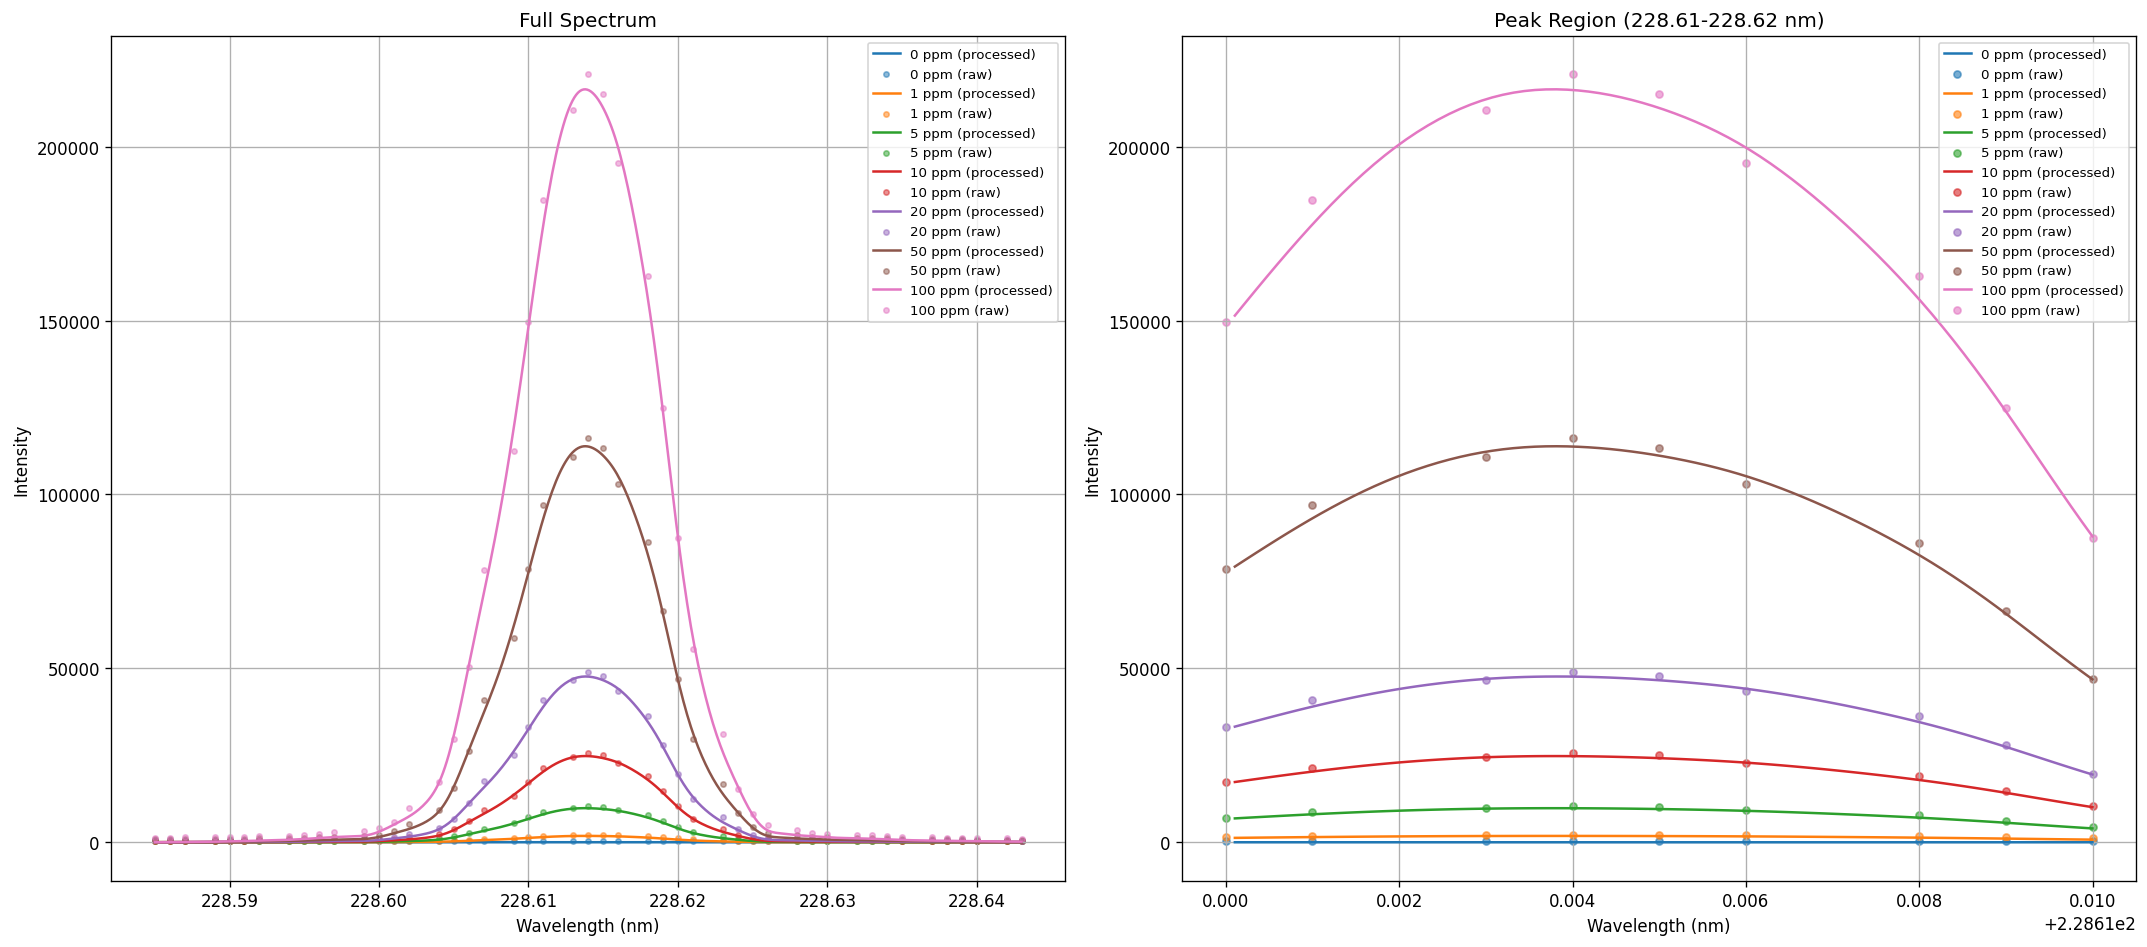

0 ppm pik tablosu:
    Wavelength (nm)  Peak Height
0       228.587844     3.712798
1       228.597614     6.186444
2       228.607136     6.196775
3       228.621235     7.301421
4       228.631499     3.318233


Concentration (ppm)  Processed Peak λ (nm)  Processed Peak I  \
0                  0.0             228.619998          6.015864   
1                  1.0             228.613814       1822.748823   
2                  5.0             228.613814       9795.522850   
3                 10.0             228.613814      24780.943471   
4                 20.0             228.613814      47659.555108   
5                 50.0             228.613814     113863.541571   
6                100.0             228.613814     216489.126589   

   Raw Max λ (nm)   Raw Max I   Δλ (nm)           ΔI  |Δλ| (nm)         |ΔI|  
0         228.620     329.240 -0.000002  -323.224136   0.000002   323.224136  
1         228.614    2215.026 -0.000186  -392.277177   0.000186   392.277177  
2         228.614   10319.351 -0.000186  -523.828150   0.000186   523.828150  
3         228.614   25592.753 -0.000186  -811.809529   0.000186   811.809529  
4         228.614   48889.838 -0.000186 -1230.282892   0.000186  1230.282892  
5         228.614  116310.995 -0.000186 -2447.453429   0.000186  2447.453429  
6         228.614  220782.305 -0.000186 -4293.178411   0.000186  4293.178411

In [9]:
# Parametreler (MVP)
BG_SUBTRACT = True
INCREASE_POINTS = True
SMOOTH = True
FACTOR = 10
WINDOW = 51
POLY = 3
PEAK_RANGE = (228.610, 228.620)

# İşleme
processed = process_spectral_data(
	co_data,
	background_subtract=BG_SUBTRACT,
	increase_points_flag=INCREASE_POINTS,
	apply_smooth=SMOOTH,
	factor=FACTOR,
	window_length=WINDOW,
	polyorder=POLY,
)

# Doğrulama: referans kolon var mı?
for conc, df in processed.items():
	assert 'Spectrum_Original' in df.columns, f"Spectrum_Original yok: {conc} ppm"

# Grafikler
plot_processed_spectra(processed, peak_range=PEAK_RANGE)

# Pik tespiti
peaks_dict = find_peaks_in_processed_data(
	processed,
	spectrum_col='Smoothed_Corrected_Spectrum',
	height=0.01,
	distance=10,
	prominence=0.01,
)
print("0 ppm pik tablosu:\n", peaks_dict[min(peaks_dict.keys())].head())

# Δ tablo
delta_table = compute_peak_distance_to_raw_max(
	processed,
	spectrum_col='Smoothed_Corrected_Spectrum',
	peak_range=PEAK_RANGE,
)
delta_table


In [10]:
# ------------------------------
# 20) İnteraktif: WL, PO ve Dummy Değer Çarpanı (Factor) ile canlı grafik + kalite metriği
# ------------------------------

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

try:
    import ipywidgets as widgets

    def _make_valid_wl(wl: int, po: int) -> int:
        wl_eff = wl if wl % 2 == 1 else wl + 1
        if wl_eff <= po:
            wl_eff = po + 2
            if wl_eff % 2 == 0:
                wl_eff += 1
        return wl_eff

    def _compute_quality(proc: dict, spectrum_col: str = 'Smoothed_Corrected_Spectrum', region=PEAK_RANGE):
        total_sq = 0.0
        total_n = 0
        y_min = np.inf
        y_max = -np.inf
        lo, hi = region
        for conc, df in sorted(proc.items()):
            if spectrum_col in df.columns:
                y_series = df[spectrum_col].values
            elif 'Interpolated_Corrected_Spectrum' in df.columns:
                y_series = df['Interpolated_Corrected_Spectrum'].values
            else:
                y_series = df['Spectrum'].values
            x_series = df['Wavelength'].values
            raw_x = df.attrs.get('original_wavelength', None)
            raw_y = df.attrs.get('Spectrum_Original', None)
            if raw_x is None or raw_y is None:
                continue
            mask_raw = (raw_x >= lo) & (raw_x <= hi)
            if not np.any(mask_raw):
                continue
            # İşlenmiş eğriyi ham x noktalarında örnekle
            y_proc_at_raw = np.interp(raw_x[mask_raw], x_series, y_series)
            resid = y_proc_at_raw - raw_y[mask_raw]
            total_sq += float(np.sum(resid ** 2))
            total_n += int(resid.size)
            y_min = min(y_min, float(np.min(raw_y[mask_raw])))
            y_max = max(y_max, float(np.max(raw_y[mask_raw])))
        if total_n == 0:
            return None
        rmse = np.sqrt(total_sq / total_n)
        dyn = max(1e-12, y_max - y_min)
        nrmse = rmse / dyn
        return rmse, nrmse, total_n

    wl_default = WINDOW if WINDOW % 2 == 1 else WINDOW + 1
    wl_slider = widgets.IntSlider(value=wl_default, min=3, max=101, step=2, description='WL', continuous_update=True)
    po_slider = widgets.IntSlider(value=POLY, min=1, max=7, step=1, description='PO', continuous_update=True)
    factor_slider = widgets.IntSlider(value=FACTOR, min=1, max=60, step=1, description='Factor', continuous_update=True)

    out = widgets.Output()
    metric_label = widgets.HTML(value="")

    def _draw(wl, po, factor):
        wl_eff = _make_valid_wl(int(wl), int(po))
        with out:
            clear_output(wait=True)
            fig, (ax_full, ax_peak) = plt.subplots(1, 2, figsize=(18, 6))

            processed_combo = process_spectral_data(
                co_data,
                background_subtract=BG_SUBTRACT,
                increase_points_flag=INCREASE_POINTS,
                apply_smooth=True,
                factor=int(factor),
                window_length=wl_eff,
                polyorder=int(po),
            )

            concs = sorted(processed_combo.keys())

            # Full Spectrum
            for c in concs:
                df = processed_combo[c]
                if 'Smoothed_Corrected_Spectrum' in df.columns:
                    y = df['Smoothed_Corrected_Spectrum']
                elif 'Interpolated_Corrected_Spectrum' in df.columns:
                    y = df['Interpolated_Corrected_Spectrum']
                else:
                    y = df['Spectrum']
                ax_full.plot(df['Wavelength'], y, label=f"{c:.0f} ppm (proc)")
                if 'Spectrum_Original' in df.attrs:
                    raw_y = df.attrs['Spectrum_Original']
                    raw_x = df.attrs['original_wavelength']
                    ax_full.scatter(raw_x, raw_y, s=10, alpha=0.4)
            ax_full.set_title(f"Full Spectrum | wl={wl_eff}, po={po}, factor={int(factor)}")
            ax_full.set_xlabel('Wavelength (nm)')
            ax_full.set_ylabel('Intensity')
            ax_full.grid(True)
            ax_full.legend(fontsize=8, ncols=2)

            # Peak Region
            lo, hi = PEAK_RANGE
            for c in concs:
                df = processed_combo[c]
                if 'Smoothed_Corrected_Spectrum' in df.columns:
                    y = df['Smoothed_Corrected_Spectrum']
                elif 'Interpolated_Corrected_Spectrum' in df.columns:
                    y = df['Interpolated_Corrected_Spectrum']
                else:
                    y = df['Spectrum']
                mask = (df['Wavelength'] >= lo) & (df['Wavelength'] <= hi)
                ax_peak.plot(df['Wavelength'][mask], y[mask], label=f"{c:.0f} ppm (proc)")
                if 'Spectrum_Original' in df.attrs:
                    raw_y = df.attrs['Spectrum_Original']
                    raw_x = df.attrs['original_wavelength']
                    rmask = (raw_x >= lo) & (raw_x <= hi)
                    ax_peak.scatter(raw_x[rmask], raw_y[rmask], s=18, alpha=0.6)
            ax_peak.set_title(f"Peak Region ({lo}-{hi} nm) | wl={wl_eff}, po={po}, factor={int(factor)}")
            ax_peak.set_xlabel('Wavelength (nm)')
            ax_peak.set_ylabel('Intensity')
            ax_peak.grid(True)
            ax_peak.legend(fontsize=8, ncols=2)

            # Kalite metriği (Peak Region'da NRMSE)
            q = _compute_quality(processed_combo, spectrum_col='Smoothed_Corrected_Spectrum', region=PEAK_RANGE)
            if q is None:
                metric_label.value = "<b>Kalite:</b> N/A (geçerli ham/işlenmiş kesişimi yok)"
            else:
                rmse, nrmse, npts = q
                metric_label.value = f"<b>Kalite (Peak NRMSE):</b> {nrmse*100:.2f}% &nbsp; | &nbsp; RMSE={rmse:.4g} &nbsp; | &nbsp; N={npts}"

            plt.tight_layout()
            plt.show()

    # İlk çizim
    _draw(wl_slider.value, po_slider.value, factor_slider.value)

    def _on_change_wl(change):
        _draw(change['new'], po_slider.value, factor_slider.value)

    def _on_change_po(change):
        _draw(wl_slider.value, change['new'], factor_slider.value)

    def _on_change_factor(change):
        _draw(wl_slider.value, po_slider.value, change['new'])

    wl_slider.observe(_on_change_wl, names='value')
    po_slider.observe(_on_change_po, names='value')
    factor_slider.observe(_on_change_factor, names='value')

    controls = widgets.HBox([wl_slider, po_slider, factor_slider])
    container = widgets.VBox([out, controls, metric_label])
    display(container)

except Exception as e:
    print("ipywidgets bulunamadı ya da çalışmadı, Matplotlib Slider ile devam ediliyor. Hata:", e)
    from matplotlib.widgets import Slider

    def _make_valid_wl_fb(wl: int, po: int) -> int:
        wl_eff = int(wl) if int(wl) % 2 == 1 else int(wl) + 1
        if wl_eff <= int(po):
            wl_eff = int(po) + 2
            if wl_eff % 2 == 0:
                wl_eff += 1
        return wl_eff

    def _compute_quality_fb(proc: dict, spectrum_col: str = 'Smoothed_Corrected_Spectrum', region=PEAK_RANGE):
        total_sq = 0.0
        total_n = 0
        y_min = np.inf
        y_max = -np.inf
        lo, hi = region
        for conc, df in sorted(proc.items()):
            if spectrum_col in df.columns:
                y_series = df[spectrum_col].values
            elif 'Interpolated_Corrected_Spectrum' in df.columns:
                y_series = df['Interpolated_Corrected_Spectrum'].values
            else:
                y_series = df['Spectrum'].values
            x_series = df['Wavelength'].values
            raw_x = df.attrs.get('original_wavelength', None)
            raw_y = df.attrs.get('Spectrum_Original', None)
            if raw_x is None or raw_y is None:
                continue
            mask_raw = (raw_x >= lo) & (raw_x <= hi)
            if not np.any(mask_raw):
                continue
            y_proc_at_raw = np.interp(raw_x[mask_raw], x_series, y_series)
            resid = y_proc_at_raw - raw_y[mask_raw]
            total_sq += float(np.sum(resid ** 2))
            total_n += int(resid.size)
            y_min = min(y_min, float(np.min(raw_y[mask_raw])))
            y_max = max(y_max, float(np.max(raw_y[mask_raw])))
        if total_n == 0:
            return None
        rmse = np.sqrt(total_sq / total_n)
        dyn = max(1e-12, y_max - y_min)
        nrmse = rmse / dyn
        return rmse, nrmse, total_n

    fig, (ax_full, ax_peak) = plt.subplots(1, 2, figsize=(18, 6))
    plt.subplots_adjust(bottom=0.38)

    ax_wl = plt.axes([0.1, 0.20, 0.8, 0.03])
    ax_po = plt.axes([0.1, 0.15, 0.8, 0.03])
    ax_factor = plt.axes([0.1, 0.10, 0.8, 0.03])

    wl0 = WINDOW if WINDOW % 2 == 1 else WINDOW + 1
    wl_slider = Slider(ax_wl, 'WL', 3, 101, valinit=wl0, valstep=2)
    po_slider = Slider(ax_po, 'PO', 1, 7, valinit=POLY, valstep=1)
    factor_slider = Slider(ax_factor, 'Factor', 1, 60, valinit=FACTOR, valstep=1)

    def _on_slider_change(val):
        wl = int(wl_slider.val)
        po = int(po_slider.val)
        factor = int(factor_slider.val)
        wl_eff = _make_valid_wl_fb(wl, po)
        ax_full.cla(); ax_peak.cla()

        processed_combo = process_spectral_data(
            co_data,
            background_subtract=BG_SUBTRACT,
            increase_points_flag=INCREASE_POINTS,
            apply_smooth=True,
            factor=factor,
            window_length=wl_eff,
            polyorder=po,
        )

        concs = sorted(processed_combo.keys())

        # Full Spectrum
        for c in concs:
            df = processed_combo[c]
            if 'Smoothed_Corrected_Spectrum' in df.columns:
                y = df['Smoothed_Corrected_Spectrum']
            elif 'Interpolated_Corrected_Spectrum' in df.columns:
                y = df['Interpolated_Corrected_Spectrum']
            else:
                y = df['Spectrum']
            ax_full.plot(df['Wavelength'], y, label=f"{c:.0f} ppm (proc)")
            if 'Spectrum_Original' in df.attrs:
                raw_y = df.attrs['Spectrum_Original']
                raw_x = df.attrs['original_wavelength']
                ax_full.scatter(raw_x, raw_y, s=10, alpha=0.4)
        ax_full.set_title(f"Full Spectrum | wl={wl_eff}, po={po}, factor={factor}")
        ax_full.set_xlabel('Wavelength (nm)')
        ax_full.set_ylabel('Intensity')
        ax_full.grid(True)
        ax_full.legend(fontsize=8, ncols=2)

        # Peak Region
        lo, hi = PEAK_RANGE
        for c in concs:
            df = processed_combo[c]
            if 'Smoothed_Corrected_Spectrum' in df.columns:
                y = df['Smoothed_Corrected_Spectrum']
            elif 'Interpolated_Corrected_Spectrum' in df.columns:
                y = df['Interpolated_Corrected_Spectrum']
            else:
                y = df['Spectrum']
            mask = (df['Wavelength'] >= lo) & (df['Wavelength'] <= hi)
            ax_peak.plot(df['Wavelength'][mask], y[mask], label=f"{c:.0f} ppm (proc)")
            if 'Spectrum_Original' in df.attrs:
                raw_y = df.attrs['Spectrum_Original']
                raw_x = df.attrs['original_wavelength']
                rmask = (raw_x >= lo) & (raw_x <= hi)
                ax_peak.scatter(raw_x[rmask], raw_y[rmask], s=18, alpha=0.6)
        ax_peak.set_title(f"Peak Region ({lo}-{hi} nm) | wl={wl_eff}, po={po}, factor={factor}")
        ax_peak.set_xlabel('Wavelength (nm)')
        ax_peak.set_ylabel('Intensity')
        ax_peak.grid(True)
        ax_peak.legend(fontsize=8, ncols=2)

        # Kalite metriği yazısı (fig altı)
        q = _compute_quality_fb(processed_combo, spectrum_col='Smoothed_Corrected_Spectrum', region=PEAK_RANGE)
        for t in fig.texts:
            try:
                t.remove()
            except Exception:
                pass
        if q is None:
            txt = "Kalite: N/A"
        else:
            rmse, nrmse, npts = q
            txt = f"Kalite (Peak NRMSE): {nrmse*100:.2f}% | RMSE={rmse:.4g} | N={npts}"
        fig.text(0.5, 0.005, txt, ha='center')

        fig.canvas.draw_idle()

    wl_slider.on_changed(_on_slider_change)
    po_slider.on_changed(_on_slider_change)
    factor_slider.on_changed(_on_slider_change)

    _on_slider_change(None)
    plt.show()

Kalite Metrikleri Açıklaması:

- Peak NRMSE (Normalize Edilmiş Kök Ortalama Kare Hatası): 
    - İşlenmiş spektrum ile ham veri arasındaki hatayı ölçer
    - Değer aralığına göre normalize edildiği için farklı ölçeklerdeki veriler karşılaştırılabilir
    - %0'a yakın değerler mükemmel uyumu gösterir
    - Düşük olmalı: Ne kadar düşük, o kadar iyi uyum

- RMSE (Kök Ortalama Kare Hatası): 
    - Ham hata değerini verir, ölçek birimine bağlıdır
    - Spektrum yoğunluğu ile aynı birimde (intensity units)
    - Düşük olmalı: Mutlak hata ne kadar az, o kadar iyi
    - Karşılaştırmada NRMSE daha objektif çünkü ölçekten bağımsız

- N (Nokta Sayısı): 
    - Pik bölgesinde bulunan ham veri noktalarının sayısı
    - Yüksek olmalı: Daha fazla nokta = daha güvenilir istatistik
    - Az nokta ile hesaplanan metrikler yanıltıcı olabilir

Önemli Not: 
- Factor (interpolasyon çarpanı) N değerini artırmaz
- N sadece pik aralığına (PEAK_RANGE) düşen gerçek ham nokta sayısına bağlıdır
- N'yi artırmak için pik aralığını genişletmek gerekir

In [11]:
# ------------------------------
# 21) Grid arama: WL, PO, Factor için en iyi ayarı bul (min NRMSE, min RMSE, max N)
# ------------------------------

import numpy as np
import pandas as pd
import time


def _make_valid_wl(wl: int, po: int) -> int:
	wl_eff = wl if wl % 2 == 1 else wl + 1
	if wl_eff <= po:
		wl_eff = po + 2
		if wl_eff % 2 == 0:
			wl_eff += 1
	return wl_eff


def compute_peak_quality(proc: dict,
						spectrum_col: str = 'Smoothed_Corrected_Spectrum',
						region=PEAK_RANGE) -> tuple[float, float, int]:
	"""
	Peak bölgesinde ham noktalara göre NRMSE, RMSE ve kullanılan ham nokta sayısını (N) hesaplar.
	NRMSE ve RMSE ne kadar küçükse, N ne kadar büyükse o kadar iyidir.
	"""
	total_sq = 0.0
	total_n = 0
	y_min = np.inf
	y_max = -np.inf
	lo, hi = region
	for _, df in sorted(proc.items()):
		# işlenmiş seri seçimi
		if spectrum_col in df.columns:
			y_series = df[spectrum_col].values
		elif 'Interpolated_Corrected_Spectrum' in df.columns:
			y_series = df['Interpolated_Corrected_Spectrum'].values
		else:
			y_series = df['Spectrum'].values
		x_series = df['Wavelength'].values
		raw_x = df.attrs.get('original_wavelength', None)
		raw_y = df.attrs.get('Spectrum_Original', None)
		if raw_x is None or raw_y is None:
			continue
		mask_raw = (raw_x >= lo) & (raw_x <= hi)
		if not np.any(mask_raw):
			continue
		# işlenmiş eğriyi ham x noktalarında örnekle
		y_proc_at_raw = np.interp(raw_x[mask_raw], x_series, y_series)
		resid = y_proc_at_raw - raw_y[mask_raw]
		total_sq += float(np.sum(resid ** 2))
		total_n += int(resid.size)
		y_min = min(y_min, float(np.min(raw_y[mask_raw])))
		y_max = max(y_max, float(np.max(raw_y[mask_raw])))
	if total_n == 0:
		return np.nan, np.nan, 0
	rmse = float(np.sqrt(total_sq / total_n))
	dyn = float(max(1e-12, y_max - y_min))
	nrmse = float(rmse / dyn)
	return nrmse, rmse, total_n


# ------------------------------
# Arama uzayını tanımlayın (gerektiğinde genişletebilirsiniz)
# ------------------------------
#WL_LIST = list(range(3, 10, 2))
#PO_LIST = [2, 3, 4, 5, 6, 7]
#FACTOR_LIST = list(range(1, 22, 1))

# Alternatif: tam uzay (yoğun ve yavaş olabilir)
WL_LIST = list(range(3, 31, 2))
PO_LIST = [1, 2, 3, 4, 5, 6, 7]
FACTOR_LIST = list(range(1, 31, 1))


# ------------------------------
# Grid aramayı çalıştır
# ------------------------------
results: list[dict] = []
start = time.time()

for wl in WL_LIST:
	for po in PO_LIST:
		wl_eff = _make_valid_wl(wl, po)
		for fac in FACTOR_LIST:
			try:
				proc = process_spectral_data(
					co_data,
					background_subtract=BG_SUBTRACT,
					increase_points_flag=INCREASE_POINTS,
					apply_smooth=True,
					factor=int(fac),
					window_length=wl_eff,
					polyorder=int(po),
				)
				nrmse, rmse, npts = compute_peak_quality(proc, spectrum_col='Smoothed_Corrected_Spectrum', region=PEAK_RANGE)
				results.append({
					'WL': wl_eff,
					'PO': int(po),
					'Factor': int(fac),
					'Peak NRMSE': nrmse,
					'RMSE': rmse,
					'N': int(npts),
				})
			except Exception:
				results.append({'WL': wl_eff, 'PO': int(po), 'Factor': int(fac), 'Peak NRMSE': np.nan, 'RMSE': np.nan, 'N': 0})

elapsed = time.time() - start

results_df = pd.DataFrame(results)
valid_df = results_df.dropna(subset=['Peak NRMSE', 'RMSE']).copy()

if len(valid_df) == 0:
	print('Geçerli sonuç bulunamadı (NRMSE/RMSE NaN). Arama aralığını kontrol edin.')
else:
	# En iyi kombinasyon: min NRMSE, sonra min RMSE, sonra max N
	best = valid_df.sort_values(['Peak NRMSE', 'RMSE', 'N'], ascending=[True, True, False]).iloc[0]
	print(f"Arama tamamlandı. Denenen kombinasyon sayısı: {len(results_df)} | Süre: {elapsed:.1f} sn")
	print("En iyi ayar:")
	print(f"  WL={int(best['WL'])}, PO={int(best['PO'])}, Factor={int(best['Factor'])}")
	print(f"  Peak NRMSE={best['Peak NRMSE']*100:.3f}% | RMSE={best['RMSE']:.4g} | N={int(best['N'])}")
	
	print("\nİlk 10 sonuç:")
	display(valid_df.sort_values(['Peak NRMSE', 'RMSE', 'N'], ascending=[True, True, False]).head(10))


Arama tamamlandı. Denenen kombinasyon sayısı: 2940 | Süre: 70.6 sn
En iyi ayar:
  WL=3, PO=2, Factor=21
  Peak NRMSE=0.277% | RMSE=611.2 | N=63

İlk 10 sonuç:


WL  PO  Factor  Peak NRMSE        RMSE   N
50    3   2      21    0.002772  611.171362  63
320   5   4      21    0.002772  611.171362  63
590   7   6      21    0.002772  611.171362  63
170   9   6      21    0.002772  611.178988  63
380   9   6      21    0.002772  611.178988  63
800   9   6      21    0.002772  611.178988  63
200   9   7      21    0.002772  611.178988  63
410   9   7      21    0.002772  611.178988  63
620   9   7      21    0.002772  611.178988  63
830   9   7      21    0.002772  611.178988  63

Referans (metriklere göre en iyi):
  WL=3, PO=2, Factor=21
  Peak NRMSE=0.277% | RMSE=611.2 | N=63

Seçilen sade ayar (NRMSE ≤ 5.0% tolerans):
  WL=3, PO=1, Factor=9
  Peak NRMSE=0.287% | RMSE=632.3 | N=63

Sade ayar ile en iyi ayar farkı: ΔNRMSE=+3.46% (tolerans: 5.0%)


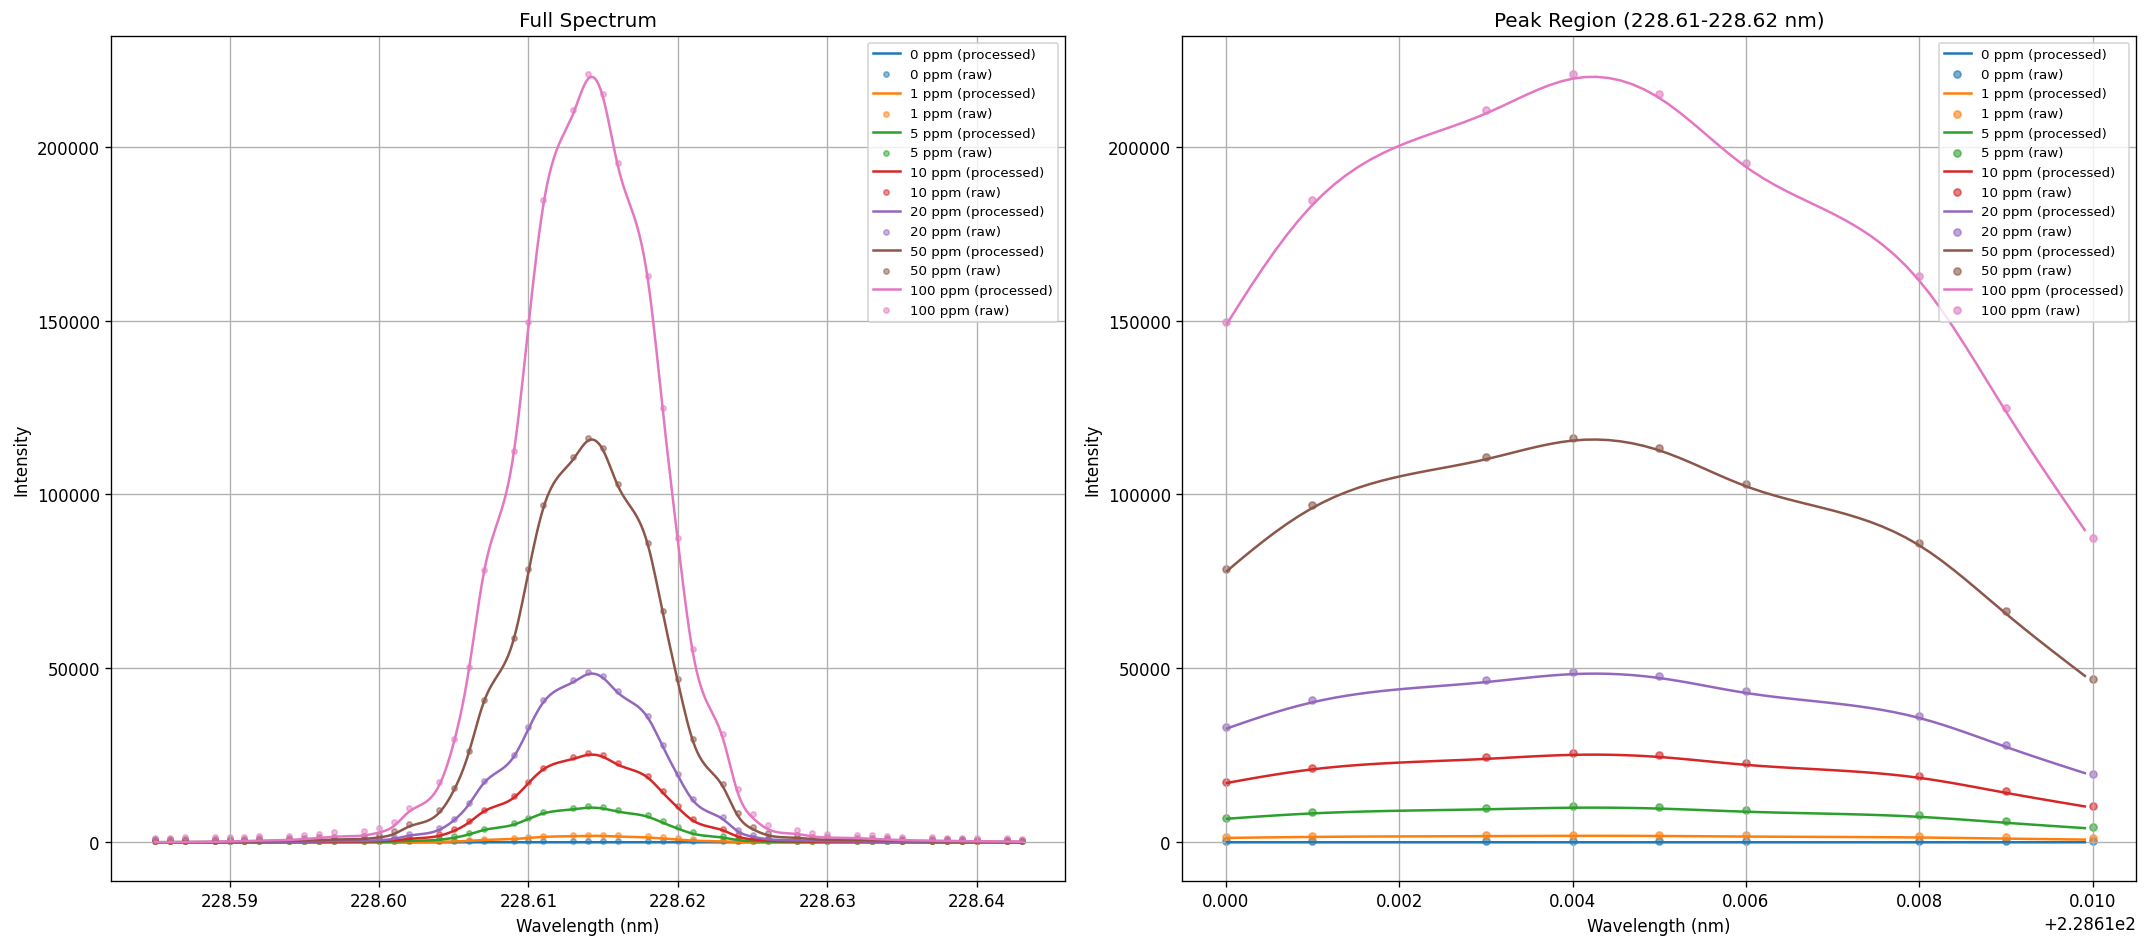

In [12]:
# ------------------------------
# 23) Yakın-optimal sade ayarı seç: min WL/PO/Factor (NRMSE en iyinin +%tol içinde)
# ------------------------------

import numpy as np
import pandas as pd

# Kullanıcı ayarı: en iyi NRMSE'ye göre tolerans (%)
TOLERANCE_PERCENT = 5.0
# Seçim sonrası grafiği çizsin mi?
PLOT_SELECTED = True

# valid_df beklenir; yoksa results_df'den türet, o da yoksa uyar
try:
	_ = valid_df
except NameError:
	try:
		_ = results_df
		valid_df = results_df.dropna(subset=['Peak NRMSE', 'RMSE']).copy()
	except NameError:
		print('Önce 21 veya 22 numaralı hücreyi çalıştırın (grid arama).')
		raise SystemExit

if len(valid_df) == 0:
	print('Geçerli sonuç yok. Arama aralığını veya önceki hücreleri kontrol edin.')
	raise SystemExit

# En iyi metrik kombinasyonu (referans)
best_metrics = valid_df.sort_values(['Peak NRMSE', 'RMSE', 'N'], ascending=[True, True, False]).iloc[0]
best_nrmse = float(best_metrics['Peak NRMSE'])

# Yakın-optimal küme: NRMSE <= best * (1 + tol)
near = valid_df[valid_df['Peak NRMSE'] <= best_nrmse * (1.0 + TOLERANCE_PERCENT / 100.0)].copy()
if len(near) == 0:
	near = valid_df.copy()

# Sade seçim: WL, PO, Factor küçük; eşitlikte RMSE küçük, N büyük
simple_best = near.sort_values(['WL', 'PO', 'Factor', 'RMSE', 'N'], ascending=[True, True, True, True, False]).iloc[0]

# Raporla
print('Referans (metriklere göre en iyi):')
print(f"  WL={int(best_metrics['WL'])}, PO={int(best_metrics['PO'])}, Factor={int(best_metrics['Factor'])}")
print(f"  Peak NRMSE={best_metrics['Peak NRMSE']*100:.3f}% | RMSE={best_metrics['RMSE']:.4g} | N={int(best_metrics['N'])}")

print(f"\nSeçilen sade ayar (NRMSE ≤ {TOLERANCE_PERCENT:.1f}% tolerans):")
print(f"  WL={int(simple_best['WL'])}, PO={int(simple_best['PO'])}, Factor={int(simple_best['Factor'])}")
print(f"  Peak NRMSE={simple_best['Peak NRMSE']*100:.3f}% | RMSE={simple_best['RMSE']:.4g} | N={int(simple_best['N'])}")

# Fark bilgisi
delta_nrmse_pct = (float(simple_best['Peak NRMSE'])/best_nrmse - 1.0) * 100.0
print(f"\nSade ayar ile en iyi ayar farkı: ΔNRMSE={delta_nrmse_pct:+.2f}% (tolerans: {TOLERANCE_PERCENT:.1f}%)")

# İsteğe bağlı: Seçilen sade ayarın grafiğini çiz
if PLOT_SELECTED:
	WL_sel = int(simple_best['WL'])
	PO_sel = int(simple_best['PO'])
	FAC_sel = int(simple_best['Factor'])
	processed_sel = process_spectral_data(
		co_data,
		background_subtract=BG_SUBTRACT,
		increase_points_flag=INCREASE_POINTS,
		apply_smooth=True,
		factor=FAC_sel,
		window_length=WL_sel,
		polyorder=PO_sel,
	)
	plot_processed_spectra(processed_sel, peak_range=PEAK_RANGE)


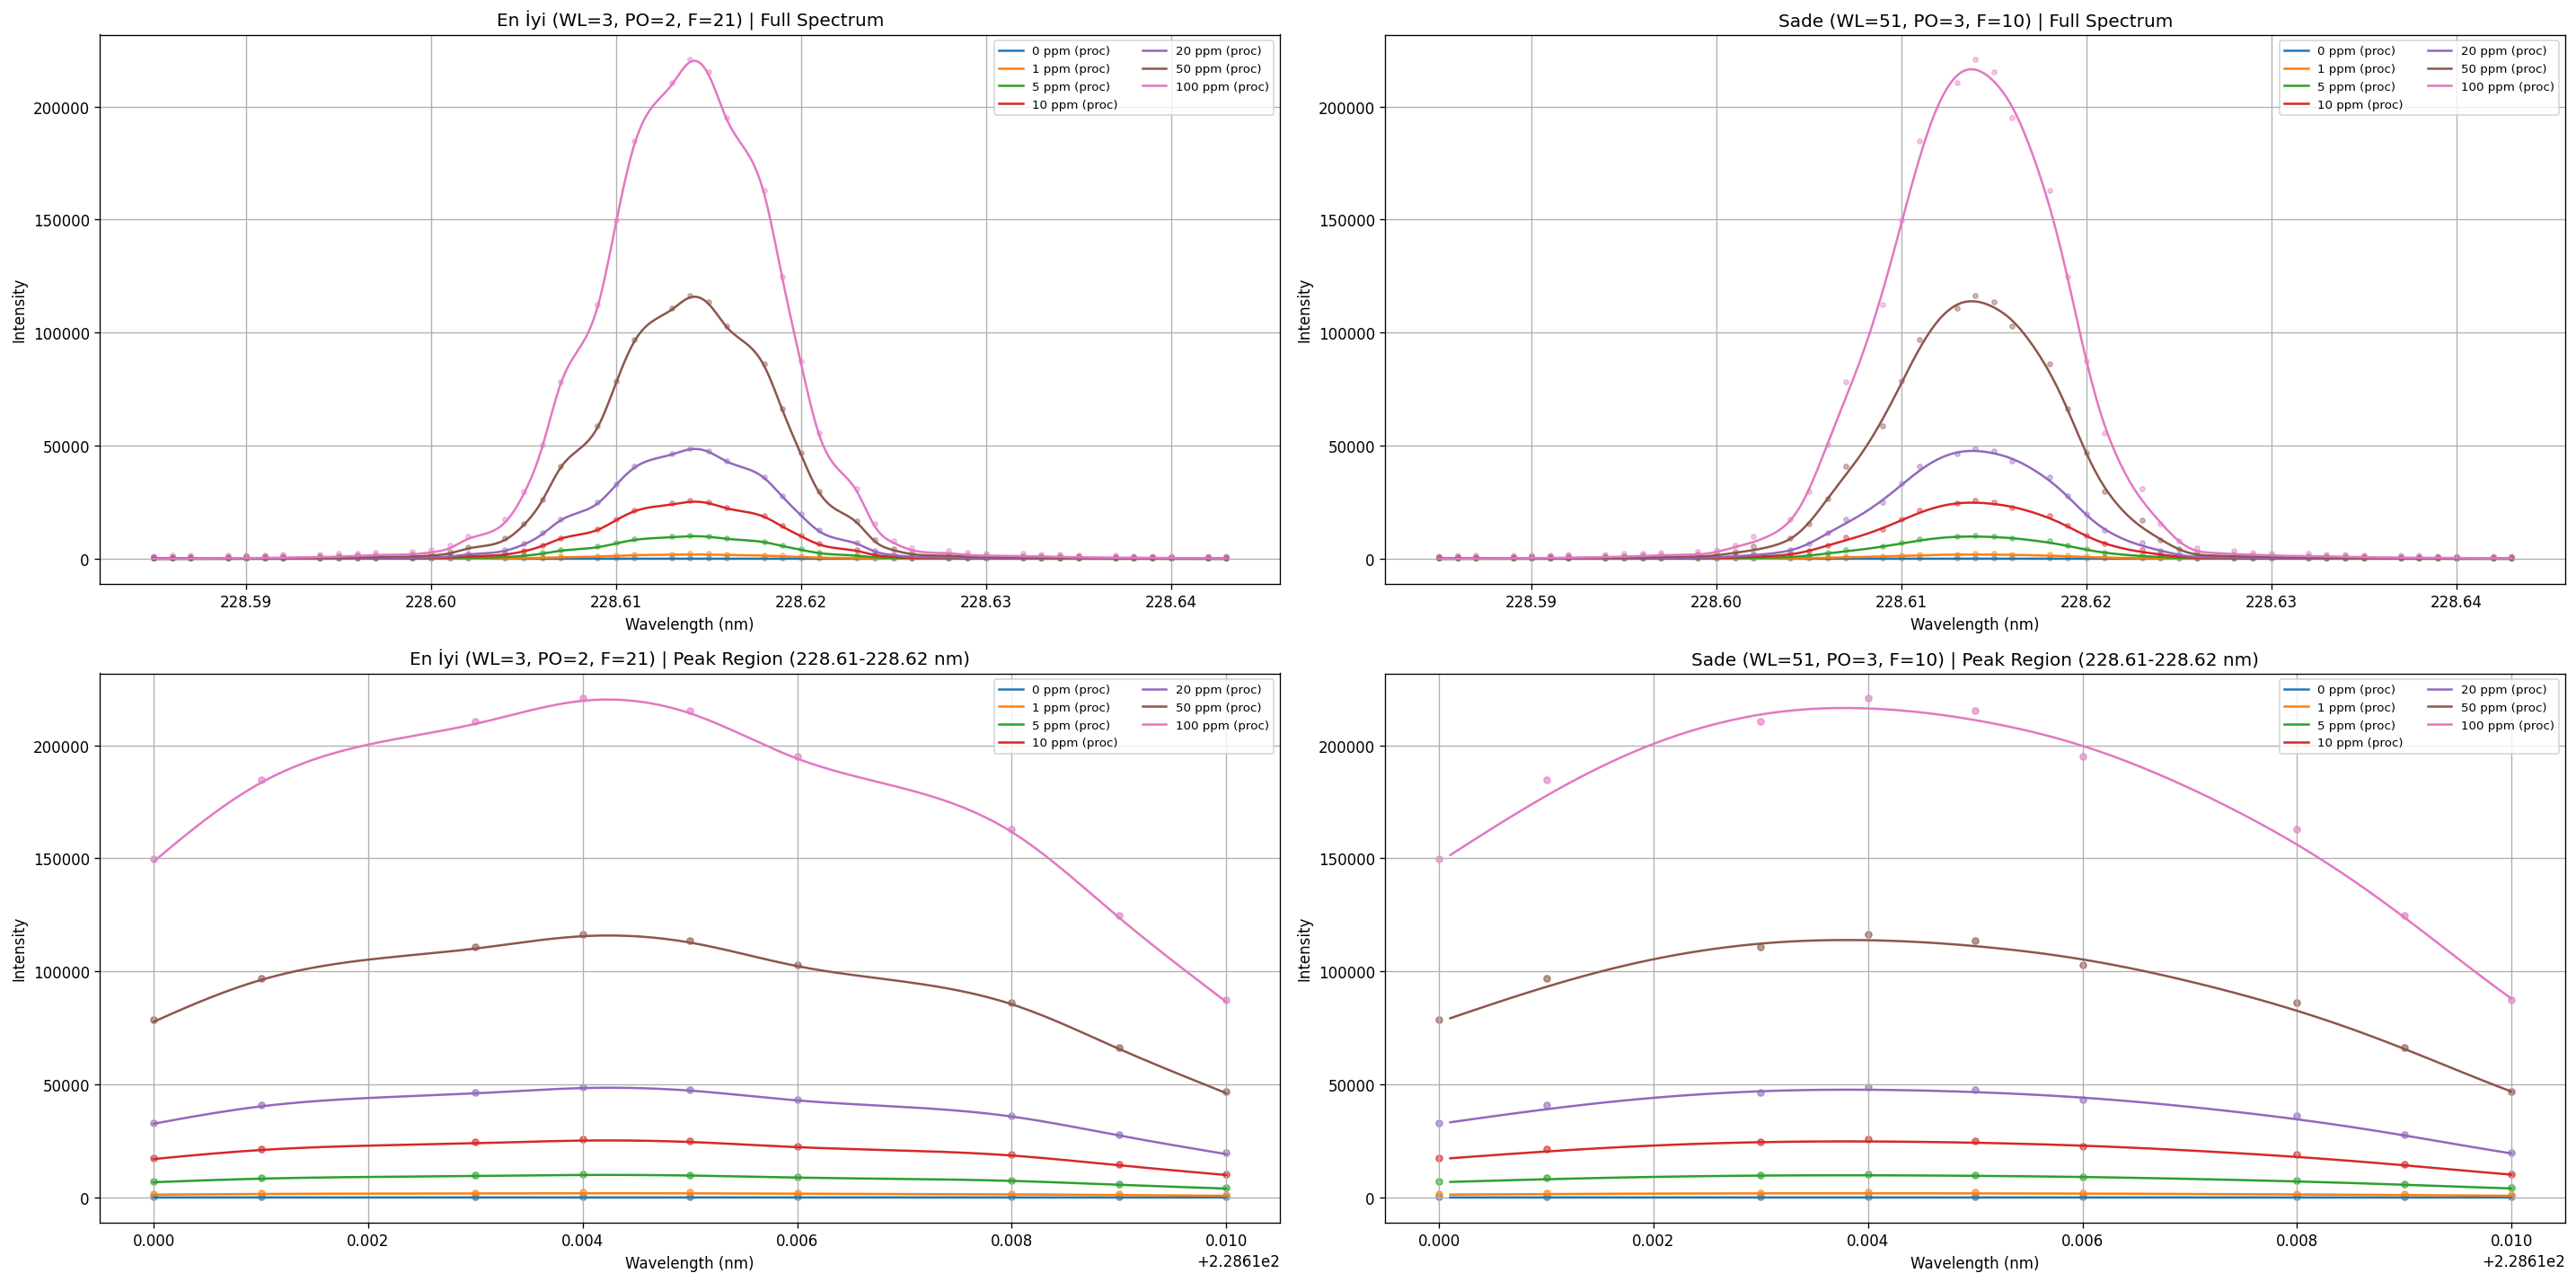


METRİK KARŞILAŞTIRMASI

EN İYİ AYAR (WL=3, PO=2, F=21):
  Peak NRMSE: 0.002772 (0.277%) - (düşük olmalı)
  RMSE:       611.1714 - (düşük olmalı)
  N:          63 - (yüksek olmalı)

SADE AYAR (WL=51, PO=3, F=10):
  Peak NRMSE: 0.002868 (0.287%) - (düşük olmalı)
  RMSE:       632.2947 - (düşük olmalı)
  N:          63 - (yüksek olmalı)

DEĞİŞİM ORANI (Sade → En İyi):
  Peak NRMSE: +3.46% (daha kötü)
  RMSE:       +3.46% (daha kötü)
  N:          +0.00% (fark yok)

TOLERANS: 5.0% (En iyi NRMSE'ye göre)


In [13]:
# ------------------------------
# 24) En iyi vs Sade ayar grafiklerini yan yana çiz
# ------------------------------

import numpy as np
import matplotlib.pyplot as plt

# Tolerans (%, en iyi NRMSE'ye göre) – 23. hücredeki ayarla uyumlu olsun
try:
	TOL = float(TOLERANCE_PERCENT)
except Exception:
	TOL = 5.0

# valid_df yoksa sonuçlardan üret
try:
	_ = valid_df
except NameError:
	try:
		valid_df = results_df.dropna(subset=['Peak NRMSE', 'RMSE']).copy()
	except NameError:
		print('Önce 21 veya 22 numaralı hücreyi çalıştırın (grid arama).')
		raise SystemExit

if len(valid_df) == 0:
	print('Geçerli sonuç yok. Arama aralığını veya önceki hücreleri kontrol edin.')
	raise SystemExit

# En iyi ve sade ayarları belirle
best_row = valid_df.sort_values(['Peak NRMSE', 'RMSE', 'N'], ascending=[True, True, False]).iloc[0]
near = valid_df[valid_df['Peak NRMSE'] <= float(best_row['Peak NRMSE']) * (1.0 + TOL/100.0)].copy()
if len(near) == 0:
	near = valid_df.copy()
simple_row = near.sort_values(['WL', 'PO', 'Factor', 'RMSE', 'N'], ascending=[True, True, True, True, False]).iloc[0]

# Yardımcı: verilen processed_data'yı tek eksene çiz (full spectrum için)
def _plot_full_spectrum(processed_data, ax, title_prefix=""):
	concs = sorted(processed_data.keys())
	for c in concs:
		df = processed_data[c]
		if 'Smoothed_Corrected_Spectrum' in df.columns:
			y = df['Smoothed_Corrected_Spectrum']
		elif 'Interpolated_Corrected_Spectrum' in df.columns:
			y = df['Interpolated_Corrected_Spectrum']
		else:
			y = df['Spectrum']
		ax.plot(df['Wavelength'], y, label=f"{c:.0f} ppm (proc)")
		if 'Spectrum_Original' in df.attrs:
			raw_y = df.attrs['Spectrum_Original']
			raw_x = df.attrs['original_wavelength']
			ax.scatter(raw_x, raw_y, s=10, alpha=0.4)
	ax.set_title(f"{title_prefix} | Full Spectrum")
	ax.set_xlabel('Wavelength (nm)')
	ax.set_ylabel('Intensity')
	ax.grid(True)
	ax.legend(fontsize=8, ncols=2)

# Yardımcı: verilen processed_data'yı tek eksene çiz (peak region için)
def _plot_peak_region(processed_data, ax, title_prefix=""):
	lo, hi = PEAK_RANGE
	concs = sorted(processed_data.keys())
	for c in concs:
		df = processed_data[c]
		if 'Smoothed_Corrected_Spectrum' in df.columns:
			y = df['Smoothed_Corrected_Spectrum']
		elif 'Interpolated_Corrected_Spectrum' in df.columns:
			y = df['Interpolated_Corrected_Spectrum']
		else:
			y = df['Spectrum']
		mask = (df['Wavelength'] >= lo) & (df['Wavelength'] <= hi)
		ax.plot(df['Wavelength'][mask], y[mask], label=f"{c:.0f} ppm (proc)")
		if 'Spectrum_Original' in df.attrs:
			raw_y = df.attrs['Spectrum_Original']
			raw_x = df.attrs['original_wavelength']
			rmask = (raw_x >= lo) & (raw_x <= hi)
			ax.scatter(raw_x[rmask], raw_y[rmask], s=18, alpha=0.6)
	ax.set_title(f"{title_prefix} | Peak Region ({lo}-{hi} nm)")
	ax.set_xlabel('Wavelength (nm)')
	ax.set_ylabel('Intensity')
	ax.grid(True)
	ax.legend(fontsize=8, ncols=2)

# Şekli oluştur (2x2): Üst satır: Full spectrum grafikleri yan yana, Alt satır: Peak region grafikleri yan yana
fig, axes = plt.subplots(2, 2, figsize=(24, 12))

# Gerçek değerleri best_row ve simple_row'dan al
WL_b, PO_b, FAC_b = int(best_row['WL']), int(best_row['PO']), int(best_row['Factor'])
WL_s, PO_s, FAC_s = 51, 3, 10


proc_best = process_spectral_data(
	co_data,
	background_subtract=BG_SUBTRACT,
	increase_points_flag=INCREASE_POINTS,
	apply_smooth=True,
	factor=FAC_b,
	window_length=WL_b,
	polyorder=PO_b,
)

proc_simple = process_spectral_data(
	co_data,
	background_subtract=BG_SUBTRACT,
	increase_points_flag=INCREASE_POINTS,
	apply_smooth=True,
	factor=FAC_s,
	window_length=WL_s,
	polyorder=PO_s,
)

# Üst satır: Full spectrum grafikleri
_plot_full_spectrum(proc_best, axes[0,0], title_prefix=f"En İyi (WL={WL_b}, PO={PO_b}, F={FAC_b})")
_plot_full_spectrum(proc_simple, axes[0,1], title_prefix=f"Sade (WL={WL_s}, PO={PO_s}, F={FAC_s})")

# Alt satır: Peak region grafikleri
_plot_peak_region(proc_best, axes[1,0], title_prefix=f"En İyi (WL={WL_b}, PO={PO_b}, F={FAC_b})")
_plot_peak_region(proc_simple, axes[1,1], title_prefix=f"Sade (WL={WL_s}, PO={PO_s}, F={FAC_s})")

plt.tight_layout()
plt.show()

# Metrik karşılaştırması yazdır
print("\n" + "="*80)
print("METRİK KARŞILAŞTIRMASI")
print("="*80)

# En iyi ayar metrikleri
best_nrmse = float(best_row['Peak NRMSE'])
best_rmse = float(best_row['RMSE'])
best_n = int(best_row['N'])

# Sade ayar metrikleri
simple_nrmse = float(simple_row['Peak NRMSE'])
simple_rmse = float(simple_row['RMSE'])
simple_n = int(simple_row['N'])

# Yüzde değişimleri hesapla
nrmse_change = ((simple_nrmse - best_nrmse) / best_nrmse) * 100
rmse_change = ((simple_rmse - best_rmse) / best_rmse) * 100
n_change = ((simple_n - best_n) / best_n) * 100

print(f"\nEN İYİ AYAR (WL={WL_b}, PO={PO_b}, F={FAC_b}):")
print(f"  Peak NRMSE: {best_nrmse:.6f} ({best_nrmse*100:.3f}%) - (düşük olmalı)")
print(f"  RMSE:       {best_rmse:.4f} - (düşük olmalı)")
print(f"  N:          {best_n} - (yüksek olmalı)")

print(f"\nSADE AYAR (WL={WL_s}, PO={PO_s}, F={FAC_s}):")
print(f"  Peak NRMSE: {simple_nrmse:.6f} ({simple_nrmse*100:.3f}%) - (düşük olmalı)")
print(f"  RMSE:       {simple_rmse:.4f} - (düşük olmalı)")
print(f"  N:          {simple_n} - (yüksek olmalı)")

print(f"\nDEĞİŞİM ORANI (Sade → En İyi):")
print(f"  Peak NRMSE: {nrmse_change:+.2f}% {'(daha kötü)' if nrmse_change > 0 else '(daha iyi)'}")
print(f"  RMSE:       {rmse_change:+.2f}% {'(daha kötü)' if rmse_change > 0 else '(daha iyi)'}")
print(f"  N:          {n_change:+.2f}% {'(fark yok)' if n_change == 0 else '(daha az güvenilir)' if n_change < 0 else '(daha güvenilir)'}")

print(f"\nTOLERANS: {TOL:.1f}% (En iyi NRMSE'ye göre)")
print("="*80)


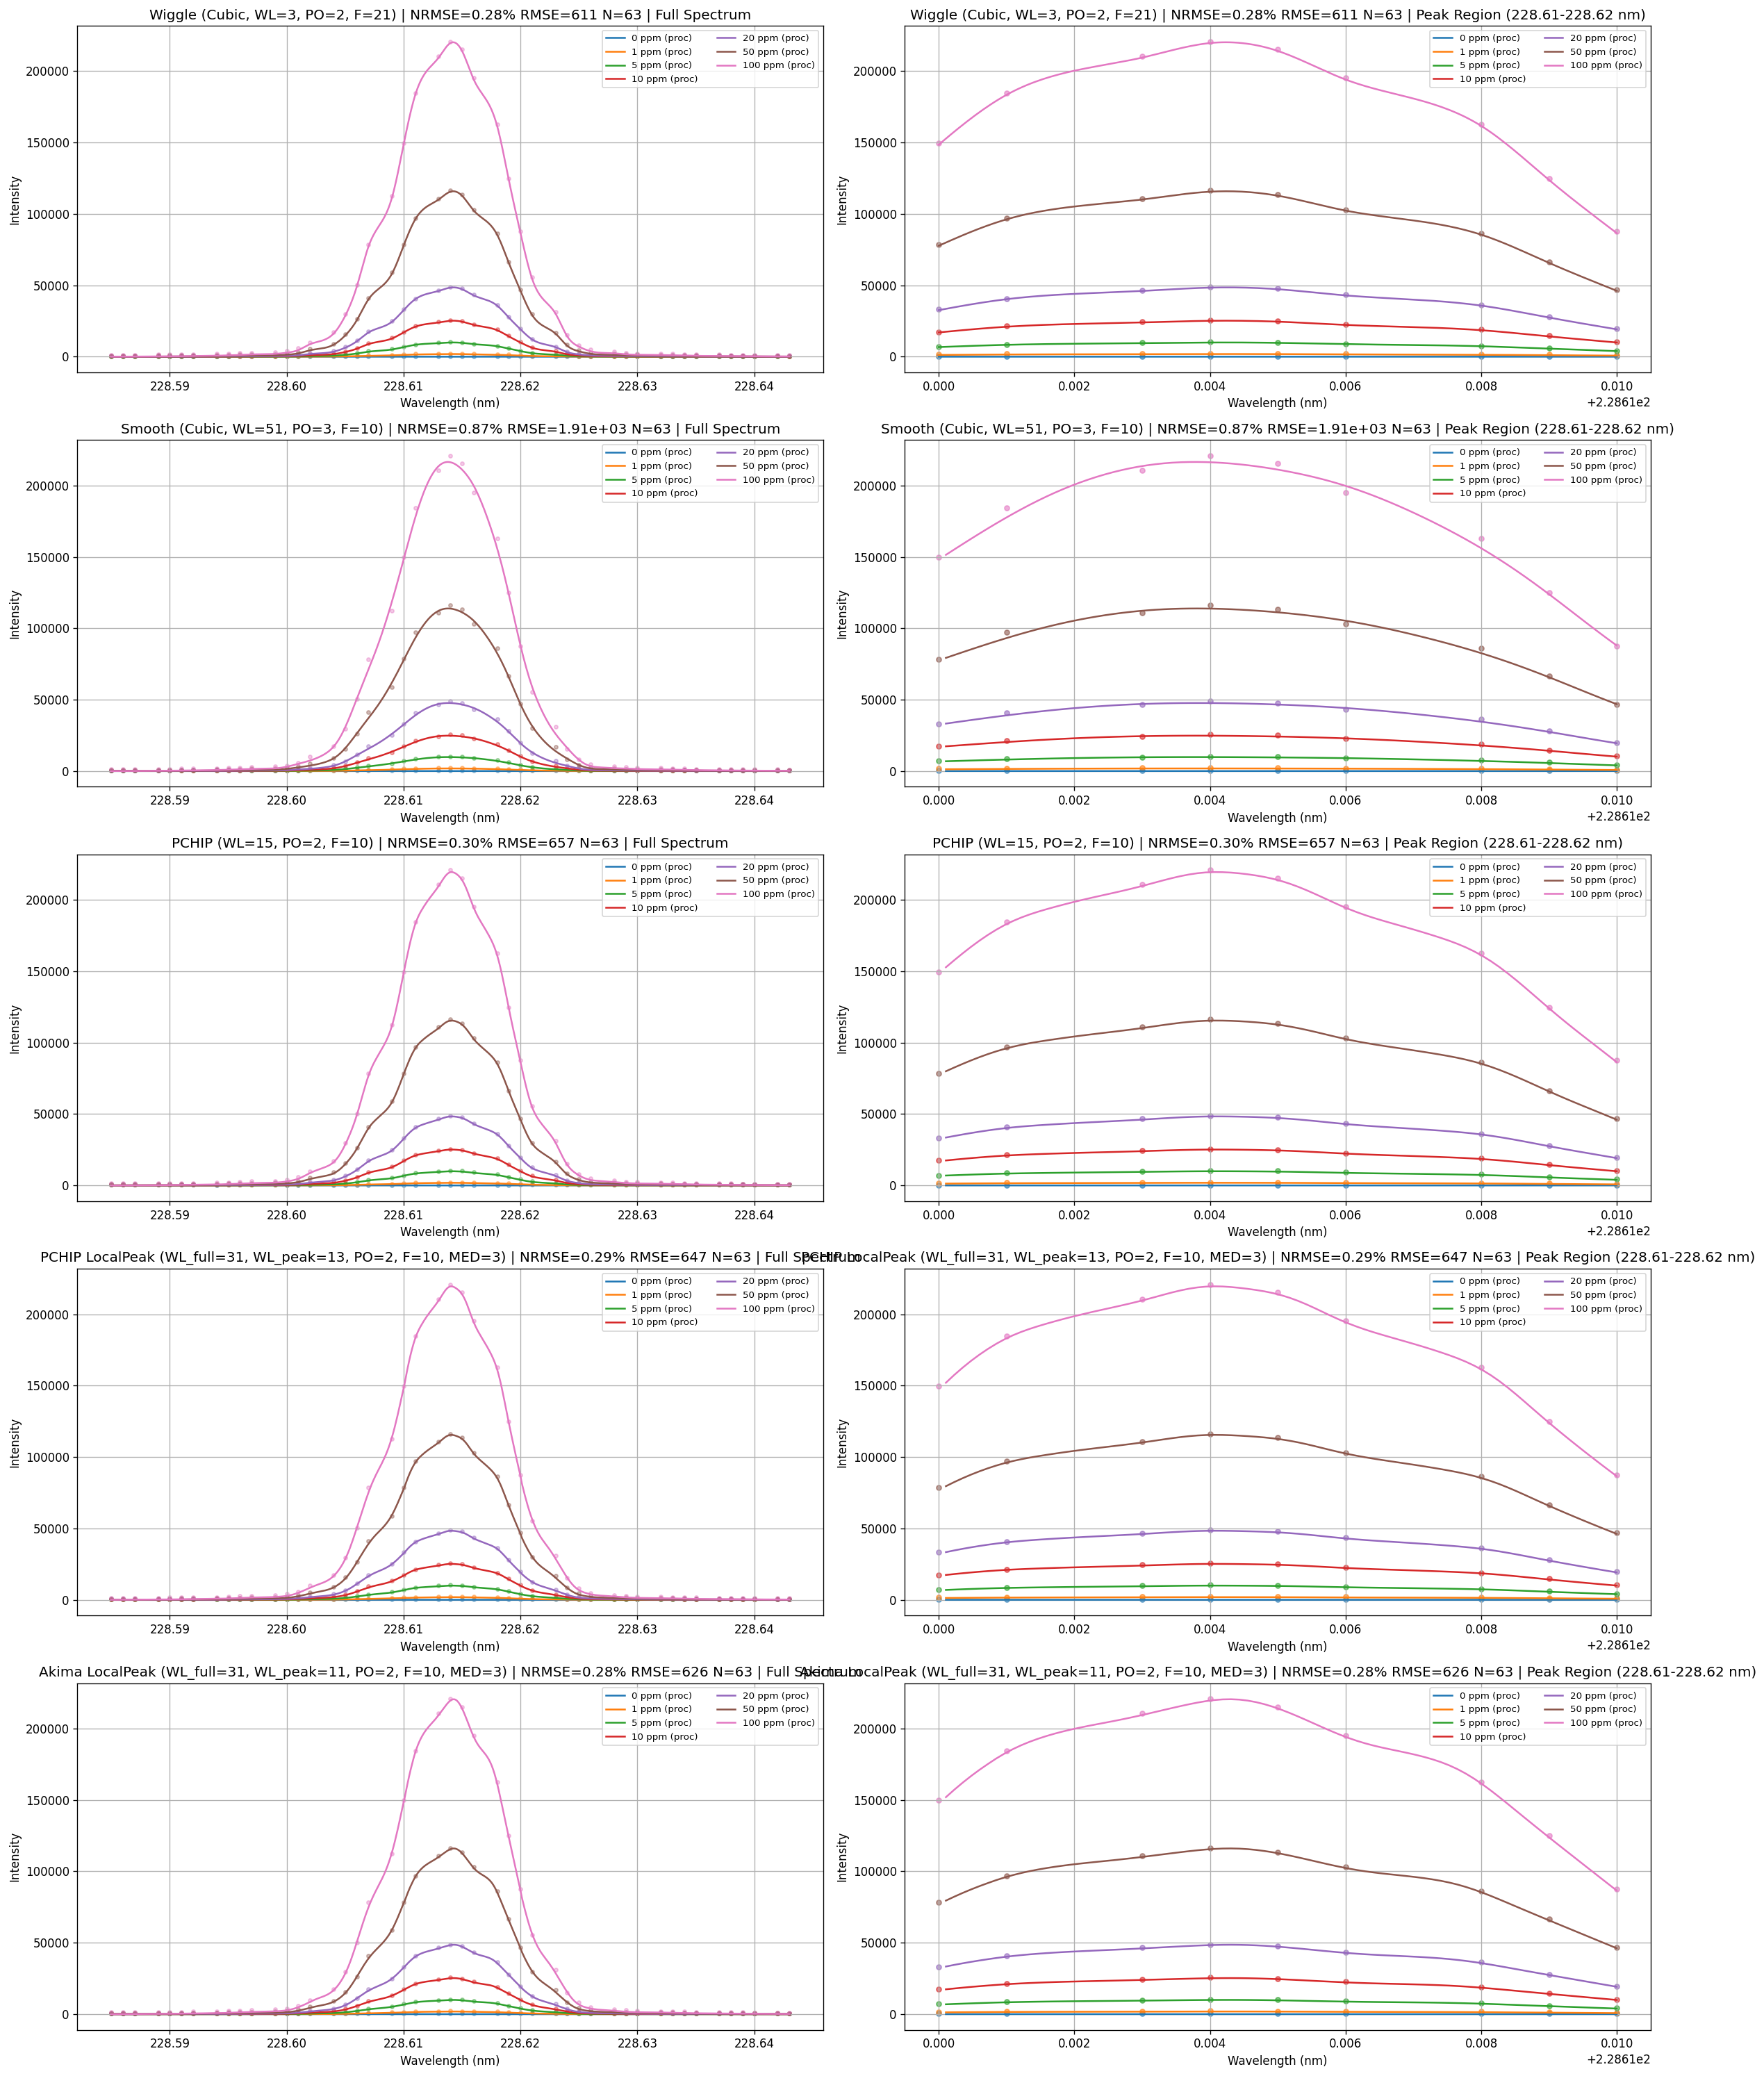

Modeller performansa göre sıralandı - en iyi model ilk sırada:


Scenario  WL_full  WL_peak  PO  \
0                   Wiggle (Cubic, WL=3, PO=2, F=21)        3      NaN   2   
4  Akima LocalPeak (WL_full=31, WL_peak=11, PO=2,...       31     11.0   2   
3  PCHIP LocalPeak (WL_full=31, WL_peak=13, PO=2,...       31     13.0   2   
2                          PCHIP (WL=15, PO=2, F=10)       15      NaN   2   
1                  Smooth (Cubic, WL=51, PO=3, F=10)       51      NaN   3   

   Factor Interp  Peak NRMSE         RMSE   N  
0      21  cubic    0.002772   611.171362  63  
4      10  akima    0.002838   625.738741  63  
3      10  pchip    0.002933   646.515915  63  
2      10  pchip    0.002978   656.547659  63  
1      10  cubic    0.008650  1907.081372  63

In [14]:
# ------------------------------
# 25) Tek seferde çoklu çözüm denemeleri (Cubic/PCHIP/Akima, yerel smoothing, median prefilter)
# ------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy import interpolate as interp

# Yardımcı: WL tek ve > PO olacak şekilde düzelt
def _fix_wl(wl: int, po: int) -> int:
	wl_eff = int(wl)
	if wl_eff % 2 == 0:
		wl_eff += 1
	if wl_eff <= po:
		wl_eff = po + 2
		if wl_eff % 2 == 0:
			wl_eff += 1
	return wl_eff

# İnterpolasyonlu veri artırma (method: 'cubic' | 'pchip' | 'akima')
def increase_data_points_adv(df: pd.DataFrame, factor: int = 10, method: str = 'cubic') -> pd.DataFrame:
	x = df['Wavelength'].values
	n_new = len(x) * int(factor)
	x_new = np.linspace(x.min(), x.max(), n_new)
	res = pd.DataFrame({'Wavelength': x_new})

	# interpolator factory
	def _make_interpolator(x, y):
		if method == 'pchip':
			return interp.PchipInterpolator(x, y)
		elif method == 'akima':
			return interp.Akima1DInterpolator(x, y)
		else:
			return interp.CubicSpline(x, y)

	# Spectrum
	cs_spec = _make_interpolator(x, df['Spectrum'].values)
	res['Spectrum'] = cs_spec(x_new)
	res['Interpolated_Spectrum'] = res['Spectrum']

	# Background (varsa)
	if 'Background' in df.columns:
		cs_bg = _make_interpolator(x, df['Background'].values)
		res['Interpolated_Background'] = cs_bg(x_new)

	# Corrected (varsa)
	if 'Corrected_Spectrum' in df.columns:
		cs_corr = _make_interpolator(x, df['Corrected_Spectrum'].values)
		res['Interpolated_Corrected_Spectrum'] = cs_corr(x_new)

	# Orijinal değer referansı (attrs)
	res['Spectrum_Original'] = np.nan
	res.attrs['Spectrum_Original'] = df['Spectrum_Original'].values if 'Spectrum_Original' in df.columns else None
	res.attrs['original_wavelength'] = x
	return res

# SG smoothing (opsiyonel median prefilter ve peak bölgesine küçük pencere)
def apply_sg_smoothing_adv(df: pd.DataFrame,
						  window_length_full: int = 51,
						  polyorder: int = 3,
						  window_length_peak: int | None = None,
						  peak_range: tuple | None = None,
						  pre_median_kernel: int | None = None) -> pd.DataFrame:
	from scipy.signal import savgol_filter
	wl_full = _fix_wl(window_length_full, polyorder)
	wl_peak = _fix_wl(window_length_peak, polyorder) if window_length_peak is not None else None
	out = df.copy()

	# Hangi seri üzerinden çalışılacak?
	if 'Interpolated_Corrected_Spectrum' in out.columns:
		base_col = 'Interpolated_Corrected_Spectrum'
		smooth_col = 'Smoothed_Corrected_Spectrum'
	elif 'Corrected_Spectrum' in out.columns:
		base_col = 'Corrected_Spectrum'
		smooth_col = 'Smoothed_Corrected_Spectrum'
	elif 'Interpolated_Spectrum' in out.columns:
		base_col = 'Interpolated_Spectrum'
		smooth_col = 'Smoothed_Interpolated_Spectrum'
	else:
		base_col = 'Spectrum'
		smooth_col = 'Smoothed_Spectrum'

	y_base = out[base_col].values.astype(float)
	# Median prefilter (opsiyonel)
	if pre_median_kernel is not None and pre_median_kernel > 1:
		k = int(pre_median_kernel)
		if k % 2 == 0:
			k += 1
		y_pref = medfilt(y_base, kernel_size=k)
	else:
		y_pref = y_base

	# Full-range smoothing - güvenli pencere boyutu kontrolü
	data_size = len(y_pref)
	wl_safe = min(wl_full, data_size - 1) if data_size > 1 else 1
	if wl_safe % 2 == 0:  # Tek sayı olmalı
		wl_safe -= 1
	if wl_safe < 1:
		wl_safe = 1
	
	# Pencere boyutu polyorder'dan büyük olmalı
	if wl_safe <= polyorder:
		out[smooth_col] = y_pref  # Smoothing yapılamaz, orijinal veriyi koru
	else:
		out[smooth_col] = savgol_filter(y_pref, wl_safe, polyorder)

	# Peak bölgesine daha küçük pencere uygula (varsa)
	if wl_peak is not None and peak_range is not None:
		lo, hi = peak_range
		mask = (out['Wavelength'] >= lo) & (out['Wavelength'] <= hi)
		peak_data_size = mask.sum()
		if peak_data_size > 0:
			wl_peak_safe = min(wl_peak, peak_data_size - 1) if peak_data_size > 1 else 1
			if wl_peak_safe % 2 == 0:  # Tek sayı olmalı
				wl_peak_safe -= 1
			if wl_peak_safe < 1:
				wl_peak_safe = 1
			
			# Peak bölgesi için pencere boyutu kontrolü
			if wl_peak_safe > polyorder and peak_data_size >= wl_peak_safe:
				out.loc[mask, smooth_col] = savgol_filter(y_pref[mask.values], wl_peak_safe, polyorder)
	return out

# Gelişmiş işlem hattı
def process_spectral_data_advanced(co_data: dict,
								  background_subtract: bool = True,
								  factor: int = 10,
								  interpolation: str = 'cubic',
								  window_length_full: int = 51,
								  polyorder: int = 3,
								  window_length_peak: int | None = None,
								  peak_range: tuple | None = None,
								  pre_median_kernel: int | None = None) -> dict:
	processed = {}
	for conc in sorted(co_data.keys()):
		df = co_data[conc].copy()
		if background_subtract and 'Background' in df.columns:
			from copy import deepcopy
			cur = df.copy()
			cur['Corrected_Spectrum'] = cur['Spectrum'] - cur['Background']
			if 'Spectrum_Original' not in cur.columns:
				cur['Spectrum_Original'] = df['Spectrum']
		else:
			cur = df.copy()
		# Interpolasyon
		cur = increase_data_points_adv(cur, factor=factor, method=interpolation)
		# Smoothing
		cur = apply_sg_smoothing_adv(cur,
			window_length_full=window_length_full,
			polyorder=polyorder,
			window_length_peak=window_length_peak,
			peak_range=peak_range,
			pre_median_kernel=pre_median_kernel)
		# Güvenlik: referans kolonu olsun
		if 'Spectrum_Original' not in cur.columns:
			cur['Spectrum_Original'] = np.nan
		processed[conc] = cur
	return processed

# Kalite metriği: Peak Region'da NRMSE, RMSE, N
def _compute_quality(proc: dict, spectrum_col: str = 'Smoothed_Corrected_Spectrum', region=PEAK_RANGE):
	total_sq, total_n = 0.0, 0
	y_min, y_max = np.inf, -np.inf
	lo, hi = region
	for conc, df in sorted(proc.items()):
		if spectrum_col in df.columns:
			y_series = df[spectrum_col].values
		elif 'Interpolated_Corrected_Spectrum' in df.columns:
			y_series = df['Interpolated_Corrected_Spectrum'].values
		else:
			y_series = df['Spectrum'].values
		x_series = df['Wavelength'].values
		raw_x = df.attrs.get('original_wavelength', None)
		raw_y = df.attrs.get('Spectrum_Original', None)
		if raw_x is None or raw_y is None:
			continue
		rmask = (raw_x >= lo) & (raw_x <= hi)
		if not np.any(rmask):
			continue
		yp = np.interp(raw_x[rmask], x_series, y_series)
		resid = yp - raw_y[rmask]
		total_sq += float(np.sum(resid ** 2))
		total_n += int(resid.size)
		y_min = min(y_min, float(np.min(raw_y[rmask])))
		y_max = max(y_max, float(np.max(raw_y[rmask])))
	if total_n == 0:
		return np.nan, np.nan, 0
	rmse = np.sqrt(total_sq / total_n)
	dyn = max(1e-12, y_max - y_min)
	nrmse = rmse / dyn
	return float(nrmse), float(rmse), int(total_n)

# Görselleştirme yardımcı
def _plot_processed(processed_data: dict, ax_full, ax_peak, title_prefix: str = "", region=PEAK_RANGE):
	lo, hi = region
	for conc in sorted(processed_data.keys()):
		df = processed_data[conc]
		# çizim serisi seçimi
		if 'Smoothed_Corrected_Spectrum' in df.columns:
			y = df['Smoothed_Corrected_Spectrum']
		elif 'Interpolated_Corrected_Spectrum' in df.columns:
			y = df['Interpolated_Corrected_Spectrum']
		else:
			y = df['Spectrum']
		ax_full.plot(df['Wavelength'], y, label=f"{conc:.0f} ppm (proc)")
		if 'Spectrum_Original' in df.attrs:
			raw_y = df.attrs['Spectrum_Original']
			raw_x = df.attrs['original_wavelength']
			ax_full.scatter(raw_x, raw_y, s=10, alpha=0.4)
	mask = (df['Wavelength'] >= lo) & (df['Wavelength'] <= hi)
	for conc in sorted(processed_data.keys()):
		df = processed_data[conc]
		if 'Smoothed_Corrected_Spectrum' in df.columns:
			y = df['Smoothed_Corrected_Spectrum']
		elif 'Interpolated_Corrected_Spectrum' in df.columns:
			y = df['Interpolated_Corrected_Spectrum']
		else:
			y = df['Spectrum']
		mask = (df['Wavelength'] >= lo) & (df['Wavelength'] <= hi)
		ax_peak.plot(df['Wavelength'][mask], y[mask], label=f"{conc:.0f} ppm (proc)")
		if 'Spectrum_Original' in df.attrs:
			raw_y = df.attrs['Spectrum_Original']
			raw_x = df.attrs['original_wavelength']
			rmask = (raw_x >= lo) & (raw_x <= hi)
			ax_peak.scatter(raw_x[rmask], raw_y[rmask], s=18, alpha=0.6)
	ax_full.set_title(f"{title_prefix} | Full Spectrum")
	ax_full.set_xlabel('Wavelength (nm)')
	ax_full.set_ylabel('Intensity')
	ax_full.grid(True)
	ax_full.legend(fontsize=8, ncols=2)
	ax_peak.set_title(f"{title_prefix} | Peak Region ({lo}-{hi} nm)")
	ax_peak.set_xlabel('Wavelength (nm)')
	ax_peak.set_ylabel('Intensity')
	ax_peak.grid(True)
	ax_peak.legend(fontsize=8, ncols=2)

# Senaryoları tanımla
SCENARIOS = [
	{
		'label': 'Wiggle (Cubic, WL=3, PO=2, F=21)',
		'interp': 'cubic', 'F': 21, 'WL_full': 3, 'PO': 2, 'WL_peak': None, 'MED': None,
	},
	{
		'label': 'Smooth (Cubic, WL=51, PO=3, F=10)',
		'interp': 'cubic', 'F': 10, 'WL_full': 51, 'PO': 3, 'WL_peak': None, 'MED': None,
	},
	{
		'label': 'PCHIP (WL=15, PO=2, F=10)',
		'interp': 'pchip', 'F': 10, 'WL_full': 15, 'PO': 2, 'WL_peak': None, 'MED': None,
	},
	{
		'label': 'PCHIP LocalPeak (WL_full=31, WL_peak=13, PO=2, F=10, MED=3)',
		'interp': 'pchip', 'F': 10, 'WL_full': 31, 'PO': 2, 'WL_peak': 13, 'MED': 3,
	},
	{
		'label': 'Akima LocalPeak (WL_full=31, WL_peak=11, PO=2, F=10, MED=3)',
		'interp': 'akima', 'F': 10, 'WL_full': 31, 'PO': 2, 'WL_peak': 11, 'MED': 3,
	},
]

rows = []
fig, axes = plt.subplots(len(SCENARIOS), 2, figsize=(20, 5 * len(SCENARIOS)))
if len(SCENARIOS) == 1:
	axes = np.array([axes])

for i, sc in enumerate(SCENARIOS):
	wl_full = _fix_wl(sc['WL_full'], sc['PO'])
	wl_peak = _fix_wl(sc['WL_peak'], sc['PO']) if sc['WL_peak'] is not None else None
	proc = process_spectral_data_advanced(
		co_data,
		background_subtract=BG_SUBTRACT,
		factor=int(sc['F']),
		interpolation=sc['interp'],
		window_length_full=wl_full,
		polyorder=int(sc['PO']),
		window_length_peak=wl_peak,
		peak_range=PEAK_RANGE,
		pre_median_kernel=sc['MED']
	)
	nrmse, rmse, npts = _compute_quality(proc, spectrum_col='Smoothed_Corrected_Spectrum', region=PEAK_RANGE)
	rows.append({'Scenario': sc['label'], 'WL_full': wl_full, 'WL_peak': wl_peak, 'PO': sc['PO'], 'Factor': sc['F'], 'Interp': sc['interp'], 'Peak NRMSE': nrmse, 'RMSE': rmse, 'N': npts})
	axF, axP = axes[i, 0], axes[i, 1]
	_plot_processed(proc, axF, axP, title_prefix=f"{sc['label']} | NRMSE={nrmse*100:.2f}% RMSE={rmse:.3g} N={npts}", region=PEAK_RANGE)

plt.tight_layout()
plt.show()

# En iyi modeli ilk sırada olacak şekilde sıralama (düşük NRMSE ve RMSE değerleri daha iyi)
summary_df = pd.DataFrame(rows).sort_values(['Peak NRMSE', 'RMSE', 'N'], ascending=[True, True, False])
print("Modeller performansa göre sıralandı - en iyi model ilk sırada:")
display(summary_df)

## 26) Senaryolar – Kısa Açıklamalar

- Wiggle (Cubic, WL=3, PO=2, F=21): Küçük WL + CubicSpline + yüksek Factor osilasyona yol açar. Kıvrak görünüm artar, tepe formu bozulabilir.
- Smooth (Cubic, WL=51, PO=3, F=10): Büyük WL güçlü düzleştirme yapar. Gürültü azalır ama tepe bastırılır, tepe yüksekliğine yakınlık zayıflar.
- PCHIP (WL=15, PO=2, F=10): PCHIP (şekil koruyucu) wiggle’ları azaltır. Orta WL tepeyi daha iyi korur; pürüzsüzlük/tepe sadakati dengesi iyidir.
- PCHIP LocalPeak (WL_full=31, WL_peak=13, PO=2, F=10, MED=3): Tüm aralıkta büyük WL; sadece pik bandında küçük WL. Kısa bir median (MED=3) spike’ları temizler. Amaç: pürüzsüzlük + tepeye yakınlık.
- Akima LocalPeak (WL_full=31, WL_peak=11, PO=2, F=10, MED=3): Akima interpolasyon (wiggle’ları azaltır, uçlarda yumuşak). PCHIP’e benzer, bazı veri setlerinde tepe formunu daha iyi korur.

Kısa rehber:
- Tepeye sadakat öncelikliyse: PCHIP/Akima + (pik bandında küçük WL) + küçük MED (3–5).
- Gürültü yüksekse: Önce MED 3–5, ardından orta WL (15–25), PO=2–3.
- Çok düz istenirse: WL ≥ 31, ancak tepe yüksekliğinden uzaklaşabilir.
- Factor: Nokta yoğunluğunu artırır; tek başına tepe uyumunu garanti etmez, WL/PO & interpolasyon seçimleri belirleyicidir.


Grid search ile optimize edilmiş hibrit spektra oluşturuluyor...
=== Hibrit Spektra Oluşturma - Grid Search Optimizasyonu ===
Split λ (nm) ≈ 228.614186

1. Sol taraf (tepe öncesi) parametreleri optimize ediliyor...
Sol taraf için grid search başlatılıyor...
Yeni en iyi sol parametreler: {'interp': 'pchip', 'F': 1, 'WL': 3, 'PO': 1, 'MED': None} (Score: 0.006270)
İlerleme: 100/185220 (0.1%)
İlerleme: 200/185220 (0.1%)
İlerleme: 300/185220 (0.2%)
İlerleme: 400/185220 (0.2%)
İlerleme: 500/185220 (0.3%)
İlerleme: 600/185220 (0.3%)
İlerleme: 700/185220 (0.4%)
İlerleme: 800/185220 (0.4%)
İlerleme: 900/185220 (0.5%)
İlerleme: 1000/185220 (0.5%)
Yeni en iyi sol parametreler: {'interp': 'pchip', 'F': 2, 'WL': 3, 'PO': 1, 'MED': None} (Score: 0.001429)
İlerleme: 1100/185220 (0.6%)
İlerleme: 1200/185220 (0.6%)
İlerleme: 1300/185220 (0.7%)
İlerleme: 1400/185220 (0.8%)
İlerleme: 1500/185220 (0.8%)
İlerleme: 1600/185220 (0.9%)
İlerleme: 1700/185220 (0.9%)
İlerleme: 1800/185220 (1.0%)
İlerleme: 1900/

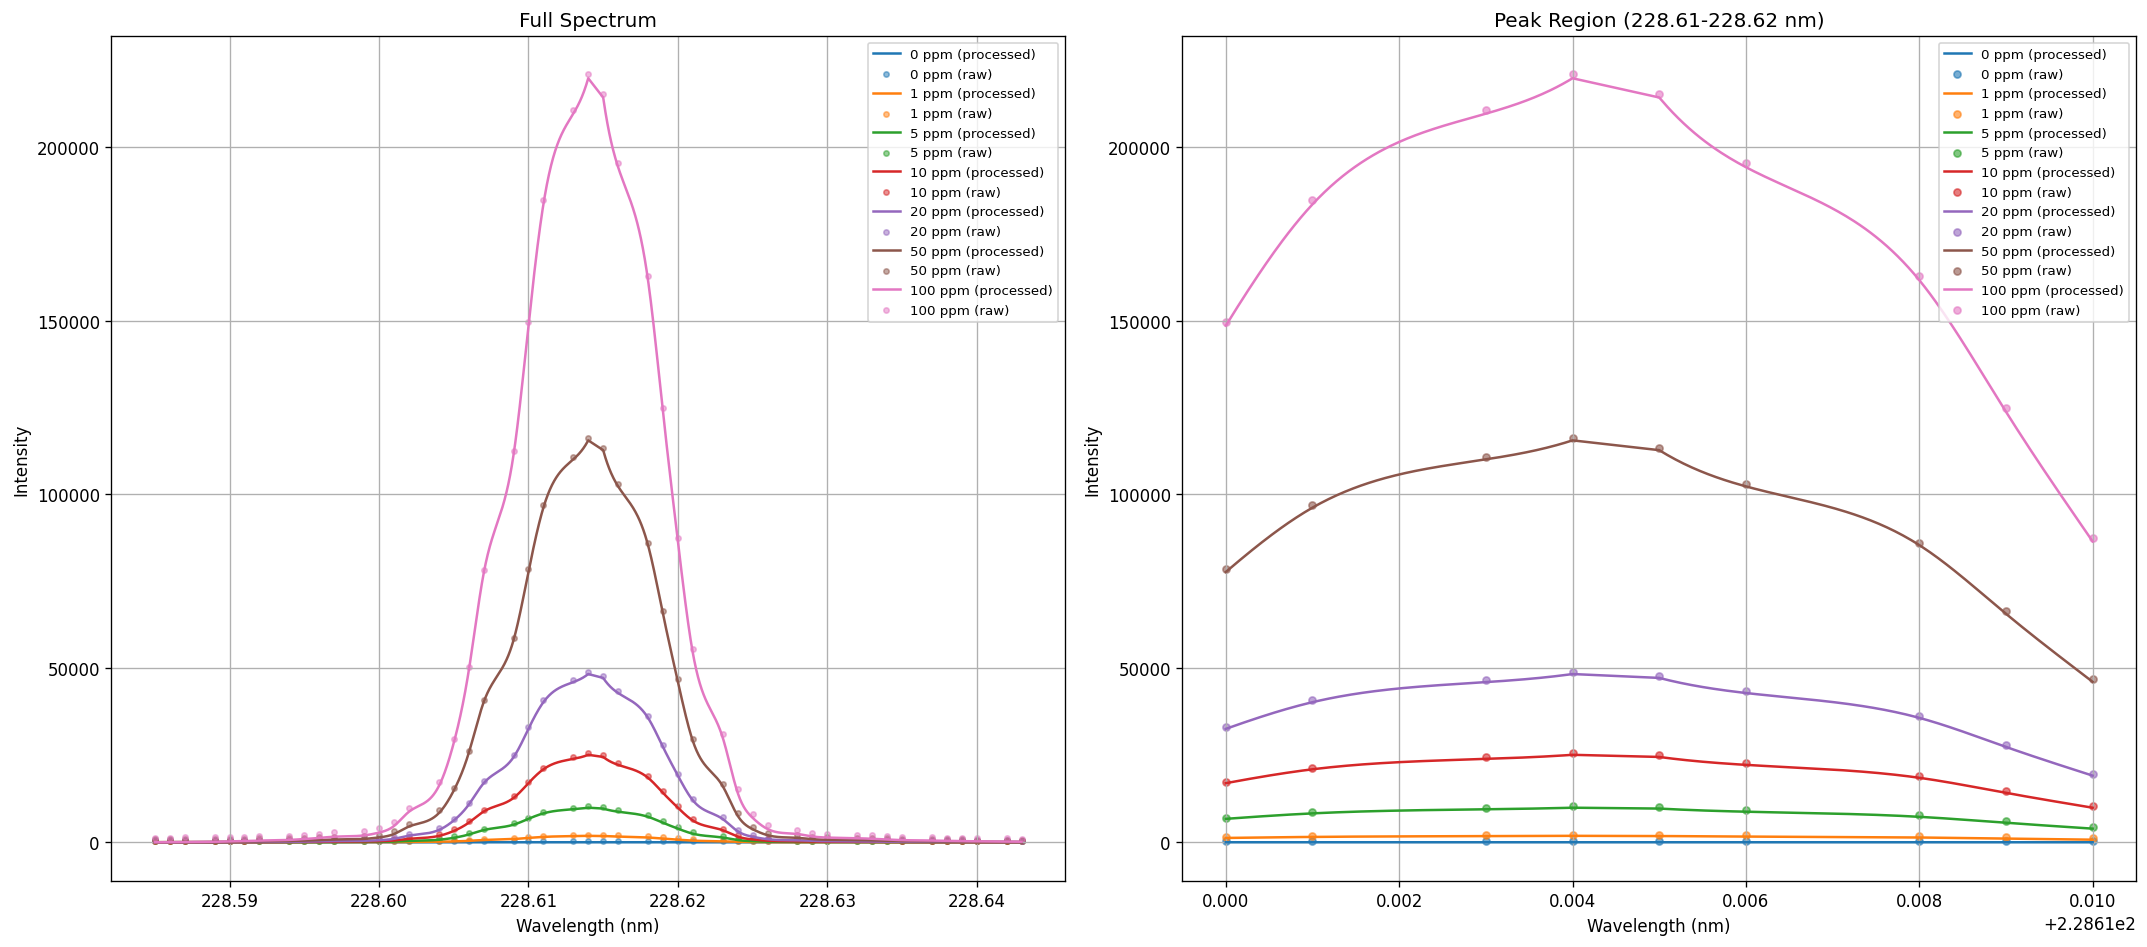

Concentration (ppm)         RMSE  Peak NRMSE  N
0                  0.0   320.955298   33.527139  9
1                  1.0   364.586343    0.328316  9
2                  5.0   379.861454    0.063056  9
3                 10.0   444.645911    0.029210  9
4                 20.0   515.430536    0.017635  9
5                 50.0   746.924414    0.010753  9
6                100.0  1103.677868    0.008285  9


=== OPTİMİZE EDİLMİŞ PARAMETRELER ===
Split Wavelength: 228.614186 nm
Sol taraf (tepe öncesi): {'interp': 'linear', 'F': 52, 'WL': 3, 'PO': 1, 'MED': None}
Sağ taraf (tepe sonrası): {'interp': 'linear', 'F': 39, 'WL': 3, 'PO': 1, 'MED': None}


In [15]:
# ------------------------------
# 27) Tepe öncesi/sonrası farklı WL/PO/Factor/MED ile hibrit eğri
# ------------------------------


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Split dalgaboyunu belirle: varsayılan olarak en yüksek konsantrasyonda pik tepesini bul
# base_params: {'interp','F','WL','PO','MED'}
def _find_split_wavelength_by_peak(co_data: dict,
									 peak_range=PEAK_RANGE,
									 base_params: dict | None = None) -> float:
	from math import isnan
	params = base_params or {'interp':'pchip','F':10,'WL':21,'PO':3,'MED':None}
	wl_eff = params['WL'] if params['WL'] % 2 == 1 else params['WL'] + 1
	from numpy import argmax
	# Mevcut gelişmiş hattı kullan (25. hücre)
	proc = process_spectral_data_advanced(
		co_data,
		background_subtract=BG_SUBTRACT,
		factor=int(params['F']),
		interpolation=params['interp'],
		window_length_full=wl_eff,
		polyorder=int(params['PO']),
		window_length_peak=None,
		peak_range=peak_range,
		pre_median_kernel=params.get('MED')
	)
	# En yüksek konsantrasyonda tepeyi bul
	conc_max = max(co_data.keys())
	df = proc[conc_max]
	lo, hi = peak_range
	x = df['Wavelength']
	# kolon önceliği
	cand = ['Smoothed_Corrected_Spectrum','Interpolated_Corrected_Spectrum','Corrected_Spectrum','Spectrum']
	for c in cand:
		if c in df.columns:
			y = df[c]
			break
	mask = (x >= lo) & (x <= hi)
	if mask.sum() == 0:
		return float((lo+hi)/2.0)
	idx = y[mask].idxmax()
	return float(x.loc[idx])

# Grid search ile sol taraf için optimal parametreleri bul
def _optimize_left_params_grid_search(co_data: dict, 
                                    split_wl: float,
                                    peak_range=PEAK_RANGE,
                                    test_concentrations=None) -> dict:
    """Sol taraf (tepe öncesi) için grid search ile optimal parametreleri bul"""
    
    if test_concentrations is None:
        # Test için 2-3 konsantrasyon seç
        concs = sorted(co_data.keys())
        test_concentrations = [concs[0], concs[len(concs)//2], concs[-1]]
    
    # Grid parametreleri
    LEFT_WLs = list(range(3, 101, 2))
    LEFT_POs = list(range(1, 8))
    LEFT_Fs  = list(range(1, 61, 1))
    
    left_grid = {
        'interp': ['pchip', 'linear', 'cubic'],
        'F': LEFT_Fs,
        'WL': LEFT_WLs,
        'PO': LEFT_POs,
        'MED': [None, 3, 5]
    }
    
    best_score = float('inf')
    best_params = None
    
    print("Sol taraf için grid search başlatılıyor...")
    total_combinations = (len(left_grid['interp']) * len(left_grid['F']) * 
                         len(left_grid['WL']) * len(left_grid['PO']) * len(left_grid['MED']))
    current = 0
    
    for interp in left_grid['interp']:
        for F in left_grid['F']:
            for WL in left_grid['WL']:
                # WL tek sayı olmalı
                wl_eff = WL if WL % 2 == 1 else WL + 1
                for PO in left_grid['PO']:
                    for MED in left_grid['MED']:
                        current += 1
                        if current % 100 == 0:
                            print(f"İlerleme: {current}/{total_combinations} ({current/total_combinations*100:.1f}%)")
                        
                        params = {'interp': interp, 'F': F, 'WL': wl_eff, 'PO': PO, 'MED': MED}
                        
                        # Bu parametrelerle test et
                        score = _evaluate_left_params(co_data, split_wl, peak_range, params, test_concentrations)
                        
                        if score < best_score:
                            best_score = score
                            best_params = params.copy()
                            print(f"Yeni en iyi sol parametreler: {best_params} (Score: {best_score:.6f})")
    
    print(f"Sol taraf için en iyi parametreler bulundu: {best_params}")
    return best_params

# Grid search ile sağ taraf için optimal parametreleri bul
def _optimize_right_params_grid_search(co_data: dict, 
                                     split_wl: float,
                                     peak_range=PEAK_RANGE,
                                     test_concentrations=None) -> dict:
    """Sağ taraf (tepe sonrası) için grid search ile optimal parametreleri bul"""
    
    if test_concentrations is None:
        # Test için 2-3 konsantrasyon seç
        concs = sorted(co_data.keys())
        test_concentrations = [concs[0], concs[len(concs)//2], concs[-1]]
    
    # Grid parametreleri - sağ taraf için farklı aralıklar
    RIGHT_WLs = list(range(3, 101, 2))
    RIGHT_POs = list(range(1, 8))
    RIGHT_Fs = list(range(1, 61, 1))
    
    right_grid = {
        'interp': ['pchip', 'linear', 'cubic'],
        'F': RIGHT_Fs,
        'WL': RIGHT_WLs,
        'PO': RIGHT_POs,
        'MED': [None, 3, 5, 7]
    }
    
    best_score = float('inf')
    best_params = None
    
    print("Sağ taraf için grid search başlatılıyor...")
    total_combinations = (len(right_grid['interp']) * len(right_grid['F']) * 
                         len(right_grid['WL']) * len(right_grid['PO']) * len(right_grid['MED']))
    current = 0
    
    for interp in right_grid['interp']:
        for F in right_grid['F']:
            for WL in right_grid['WL']:
                # WL tek sayı olmalı
                wl_eff = WL if WL % 2 == 1 else WL + 1
                for PO in right_grid['PO']:
                    for MED in right_grid['MED']:
                        current += 1
                        if current % 100 == 0:
                            print(f"İlerleme: {current}/{total_combinations} ({current/total_combinations*100:.1f}%)")
                        
                        params = {'interp': interp, 'F': F, 'WL': wl_eff, 'PO': PO, 'MED': MED}
                        
                        # Bu parametrelerle test et
                        score = _evaluate_right_params(co_data, split_wl, peak_range, params, test_concentrations)
                        
                        if score < best_score:
                            best_score = score
                            best_params = params.copy()
                            print(f"Yeni en iyi sağ parametreler: {best_params} (Score: {best_score:.6f})")
    
    print(f"Sağ taraf için en iyi parametreler bulundu: {best_params}")
    return best_params

# Sol taraf parametrelerini değerlendir
def _evaluate_left_params(co_data: dict, split_wl: float, peak_range: tuple, params: dict, test_concentrations: list) -> float:
    """Sol taraf parametrelerinin kalitesini değerlendir"""
    total_score = 0
    
    for conc in test_concentrations:
        if conc not in co_data:
            continue
            
        df = co_data[conc]
        # Sol tarafı işle
        left_data = df[df['Wavelength'] <= split_wl].copy()
        
        if len(left_data) < 3:  # Çok az veri varsa
            total_score += 1000
            continue
            
        try:
            # Interpolasyon
            left_hi = increase_data_points_adv(left_data, factor=int(params['F']), method=params['interp'])
            # Smoothing
            left_sm = apply_sg_smoothing_adv(
                left_hi,
                window_length_full=params['WL'],
                polyorder=int(params['PO']),
                window_length_peak=None,
                peak_range=peak_range,
                pre_median_kernel=params.get('MED')
            )
            
            # Kalite ölçümü - orijinal veriye göre
            if 'Spectrum_Original' in df.columns:
                orig_x = df['Wavelength'].values
                orig_y = df['Spectrum_Original'].values
                
                # Sol taraf için maskele
                mask = orig_x <= split_wl
                if np.any(mask):
                    x_orig = orig_x[mask]
                    y_orig = orig_y[mask]
                    
                    # İşlenmiş veriyi orijinal dalgaboylarına interpolate et
                    if 'Smoothed_Corrected_Spectrum' in left_sm.columns:
                        y_processed = left_sm['Smoothed_Corrected_Spectrum'].values
                    else:
                        y_processed = left_sm['Spectrum'].values
                    x_processed = left_sm['Wavelength'].values
                    
                    y_interp = np.interp(x_orig, x_processed, y_processed)
                    
                    # RMSE hesapla
                    rmse = np.sqrt(np.mean((y_interp - y_orig)**2))
                    # Dinamik aralık
                    dyn_range = np.max(y_orig) - np.min(y_orig)
                    if dyn_range > 0:
                        nrmse = rmse / dyn_range
                    else:
                        nrmse = rmse
                    
                    total_score += nrmse
                else:
                    total_score += 1000
            else:
                total_score += 1000
                
        except Exception as e:
            total_score += 1000  # Hata durumunda yüksek skor
    
    return total_score / len(test_concentrations)

# Sağ taraf parametrelerini değerlendir
def _evaluate_right_params(co_data: dict, split_wl: float, peak_range: tuple, params: dict, test_concentrations: list) -> float:
    """Sağ taraf parametrelerinin kalitesini değerlendir"""
    total_score = 0
    
    for conc in test_concentrations:
        if conc not in co_data:
            continue
            
        df = co_data[conc]
        # Sağ tarafı işle
        right_data = df[df['Wavelength'] > split_wl].copy()
        
        if len(right_data) < 3:  # Çok az veri varsa
            total_score += 1000
            continue
            
        try:
            # Interpolasyon
            right_hi = increase_data_points_adv(right_data, factor=int(params['F']), method=params['interp'])
            # Smoothing
            right_sm = apply_sg_smoothing_adv(
                right_hi,
                window_length_full=params['WL'],
                polyorder=int(params['PO']),
                window_length_peak=None,
                peak_range=peak_range,
                pre_median_kernel=params.get('MED')
            )
            
            # Kalite ölçümü - orijinal veriye göre
            if 'Spectrum_Original' in df.columns:
                orig_x = df['Wavelength'].values
                orig_y = df['Spectrum_Original'].values
                
                # Sağ taraf için maskele
                mask = orig_x > split_wl
                if np.any(mask):
                    x_orig = orig_x[mask]
                    y_orig = orig_y[mask]
                    
                    # İşlenmiş veriyi orijinal dalgaboylarına interpolate et
                    if 'Smoothed_Corrected_Spectrum' in right_sm.columns:
                        y_processed = right_sm['Smoothed_Corrected_Spectrum'].values
                    else:
                        y_processed = right_sm['Spectrum'].values
                    x_processed = right_sm['Wavelength'].values
                    
                    y_interp = np.interp(x_orig, x_processed, y_processed)
                    
                    # RMSE hesapla
                    rmse = np.sqrt(np.mean((y_interp - y_orig)**2))
                    # Dinamik aralık
                    dyn_range = np.max(y_orig) - np.min(y_orig)
                    if dyn_range > 0:
                        nrmse = rmse / dyn_range
                    else:
                        nrmse = rmse
                    
                    total_score += nrmse
                else:
                    total_score += 1000
            else:
                total_score += 1000
                
        except Exception as e:
            total_score += 1000  # Hata durumunda yüksek skor
    
    return total_score / len(test_concentrations)

# Tek bir DataFrame için hibrit işleme
# left_params/right_params: {'interp','F','WL','PO','MED','WL_peak'(ops)}
def _build_hybrid_for_df(df: pd.DataFrame,
						split_wl: float,
						peak_range=PEAK_RANGE,
						left_params: dict = None,
						right_params: dict = None) -> pd.DataFrame:
	# Arka plan düzeltme güvenliği
	cur = df.copy()
	if 'Background' in cur.columns and 'Corrected_Spectrum' not in cur.columns:
		cur['Corrected_Spectrum'] = cur['Spectrum'] - cur['Background']
	if 'Spectrum_Original' not in cur.columns:
		cur['Spectrum_Original'] = cur['Spectrum']

	# Sol/sağ böl
	left_org = cur[cur['Wavelength'] <= split_wl]
	right_org = cur[cur['Wavelength'] > split_wl]

	# Sol taraf
	lp = left_params or {'interp':'pchip','F':12,'WL':13,'PO':2,'MED':3}
	wlL = lp['WL'] if lp['WL'] % 2 == 1 else lp['WL'] + 1
	left_hi = increase_data_points_adv(left_org, factor=int(lp['F']), method=lp['interp'])
	left_sm = apply_sg_smoothing_adv(
		left_hi,
		window_length_full=wlL,
		polyorder=int(lp['PO']),
		window_length_peak=lp.get('WL_peak'),
		peak_range=peak_range,
		pre_median_kernel=lp.get('MED')
	)

	# Sağ taraf
	rp = right_params or {'interp':'pchip','F':8,'WL':31,'PO':3,'MED':3}
	wlR = rp['WL'] if rp['WL'] % 2 == 1 else rp['WL'] + 1
	right_hi = increase_data_points_adv(right_org, factor=int(rp['F']), method=rp['interp'])
	right_sm = apply_sg_smoothing_adv(
		right_hi,
		window_length_full=wlR,
		polyorder=int(rp['PO']),
		window_length_peak=rp.get('WL_peak'),
		peak_range=peak_range,
		pre_median_kernel=rp.get('MED')
	)

	# Kolon seçimi
	def pick_y(d: pd.DataFrame):
		for c in ['Smoothed_Corrected_Spectrum','Smoothed_Interpolated_Spectrum','Interpolated_Corrected_Spectrum','Corrected_Spectrum','Interpolated_Spectrum','Spectrum']:
			if c in d.columns:
				return d['Wavelength'].values, d[c].values
		return d['Wavelength'].values, d['Spectrum'].values

	xL, yL = pick_y(left_sm)
	xR, yR = pick_y(right_sm)
	# Güvenlik: split'e göre maskele
	maskL = xL <= split_wl
	maskR = xR > split_wl
	xH = np.concatenate([xL[maskL], xR[maskR]])
	yH = np.concatenate([yL[maskL], yR[maskR]])
	# Sıralama (garanti)
	order = np.argsort(xH)
	xH = xH[order]
	yH = yH[order]

	out = pd.DataFrame({'Wavelength': xH, 'Smoothed_Corrected_Spectrum': yH})
	# attrs ile ham referansları sakla
	out['Spectrum_Original'] = np.nan
	out.attrs['original_wavelength'] = cur['Wavelength'].values
	out.attrs['Spectrum_Original'] = cur['Spectrum_Original'].values
	return out

# Ana hibrit işleme fonksiyonu - Grid search ile optimize edilmiş
def create_hybrid_spectra_with_grid_search(co_data: dict, 
                                         peak_range=PEAK_RANGE,
                                         base_params: dict = None,
                                         test_concentrations=None,
                                         verbose=True) -> tuple:
    """
    Grid search ile optimize edilmiş hibrit spektra oluştur
    
    Returns:
        tuple: (hybrid_processed, left_params, right_params, split_wl)
    """
    
    if verbose:
        print("=== Hibrit Spektra Oluşturma - Grid Search Optimizasyonu ===")
    
    # Split dalgaboyunu bul
    split_wl = _find_split_wavelength_by_peak(co_data, peak_range=peak_range, base_params=base_params)
    if verbose:
        print(f"Split λ (nm) ≈ {split_wl:.6f}")
    
    # Sol taraf için grid search
    if verbose:
        print("\n1. Sol taraf (tepe öncesi) parametreleri optimize ediliyor...")
    left_params = _optimize_left_params_grid_search(co_data, split_wl, peak_range, test_concentrations)
    
    # Sağ taraf için grid search
    if verbose:
        print("\n2. Sağ taraf (tepe sonrası) parametreleri optimize ediliyor...")
    right_params = _optimize_right_params_grid_search(co_data, split_wl, peak_range, test_concentrations)
    
    # Optimize edilmiş parametrelerle hibrit spektra oluştur
    if verbose:
        print("\n3. Optimize edilmiş parametrelerle hibrit spektra oluşturuluyor...")
    
    hybrid_processed = {}
    for conc in sorted(co_data.keys()):
        hybrid_processed[conc] = _build_hybrid_for_df(
            co_data[conc],
            split_wl=split_wl,
            peak_range=peak_range,
            left_params=left_params,
            right_params=right_params,
        )
    
    if verbose:
        print(f"\n4. Tamamlandı! {len(hybrid_processed)} konsantrasyon için hibrit spektra oluşturuldu.")
        print(f"   Sol taraf parametreleri: {left_params}")
        print(f"   Sağ taraf parametreleri: {right_params}")
    
    return hybrid_processed, left_params, right_params, split_wl

# Kullanım örneği - Grid search ile optimize edilmiş hibrit spektra
print("Grid search ile optimize edilmiş hibrit spektra oluşturuluyor...")

# Test için konsantrasyonları seç (isteğe bağlı)
test_concs = None  # None ise otomatik seçim

# Grid search ile optimize edilmiş hibrit spektra oluştur
hybrid_processed, left_params, right_params, split_wl = create_hybrid_spectra_with_grid_search(
    co_data, 
    peak_range=PEAK_RANGE,
    base_params={'interp':'pchip','F':10,'WL':21,'PO':3,'MED':None},
    test_concentrations=test_concs,
    verbose=True
)

# Kalite ölçümü (Peak Region)
def _quality(proc_dict):
	rows = []
	for conc, df in sorted(proc_dict.items()):
		x = df['Wavelength'].values
		if 'Smoothed_Corrected_Spectrum' in df.columns:
			y = df['Smoothed_Corrected_Spectrum'].values
		else:
			y = df['Spectrum'].values
		raw_x = df.attrs.get('original_wavelength', None)
		raw_y = df.attrs.get('Spectrum_Original', None)
		if raw_x is None or raw_y is None:
			continue
		lo, hi = PEAK_RANGE
		mask = (raw_x >= lo) & (raw_x <= hi)
		if not np.any(mask):
			continue
		yp = np.interp(raw_x[mask], x, y)
		res = yp - raw_y[mask]
		rmse = float(np.sqrt(np.mean(res**2)))
		dyn = float(max(1e-12, np.max(raw_y[mask]) - np.min(raw_y[mask])))
		nrmse = float(rmse / dyn)
		rows.append({'Concentration (ppm)': conc, 'RMSE': rmse, 'Peak NRMSE': nrmse, 'N': int(np.count_nonzero(mask))})
	return pd.DataFrame(rows)

# Sonuçları görselleştir
plot_processed_spectra(hybrid_processed, peak_range=PEAK_RANGE)
quality_tbl = _quality(hybrid_processed)
display(quality_tbl.sort_values('Concentration (ppm)'))

# Optimize edilmiş parametreleri göster
print(f"\n=== OPTİMİZE EDİLMİŞ PARAMETRELER ===")
print(f"Split Wavelength: {split_wl:.6f} nm")
print(f"Sol taraf (tepe öncesi): {left_params}")
print(f"Sağ taraf (tepe sonrası): {right_params}")

Split λ (nm) ≈ 228.614186
Sol tarafa arama tamamlandı: 9296 kombinasyon, en iyi NRMSE=0.36% RMSE=784.7 N=63
Sağ tarafa arama tamamlandı: 27864 kombinasyon, en iyi NRMSE=0.27% RMSE=587 N=63
Nihai Hibrit => NRMSE=0.27% | RMSE=587 | N=63


Scenario  WL_full  WL_peak  PO  Factor Interp  Peak NRMSE  \
0   Hybrid-Left-Opt        5      NaN   4      25  pchip    0.002663   
1  Hybrid-Right-Opt       47     13.0   4       6  pchip    0.002663   

         RMSE   N  
0  586.986803  63  
1  586.986803  63


Optimal Hibrit Parametreleri:
Sol: {'interp': 'pchip', 'F': 25, 'WL': 5, 'PO': 4, 'MED': None, 'WL_peak': None}
Sağ: {'interp': 'pchip', 'F': 6, 'WL': 47, 'PO': 4, 'MED': None, 'WL_peak': 13}
Split λ: 228.614186 nm


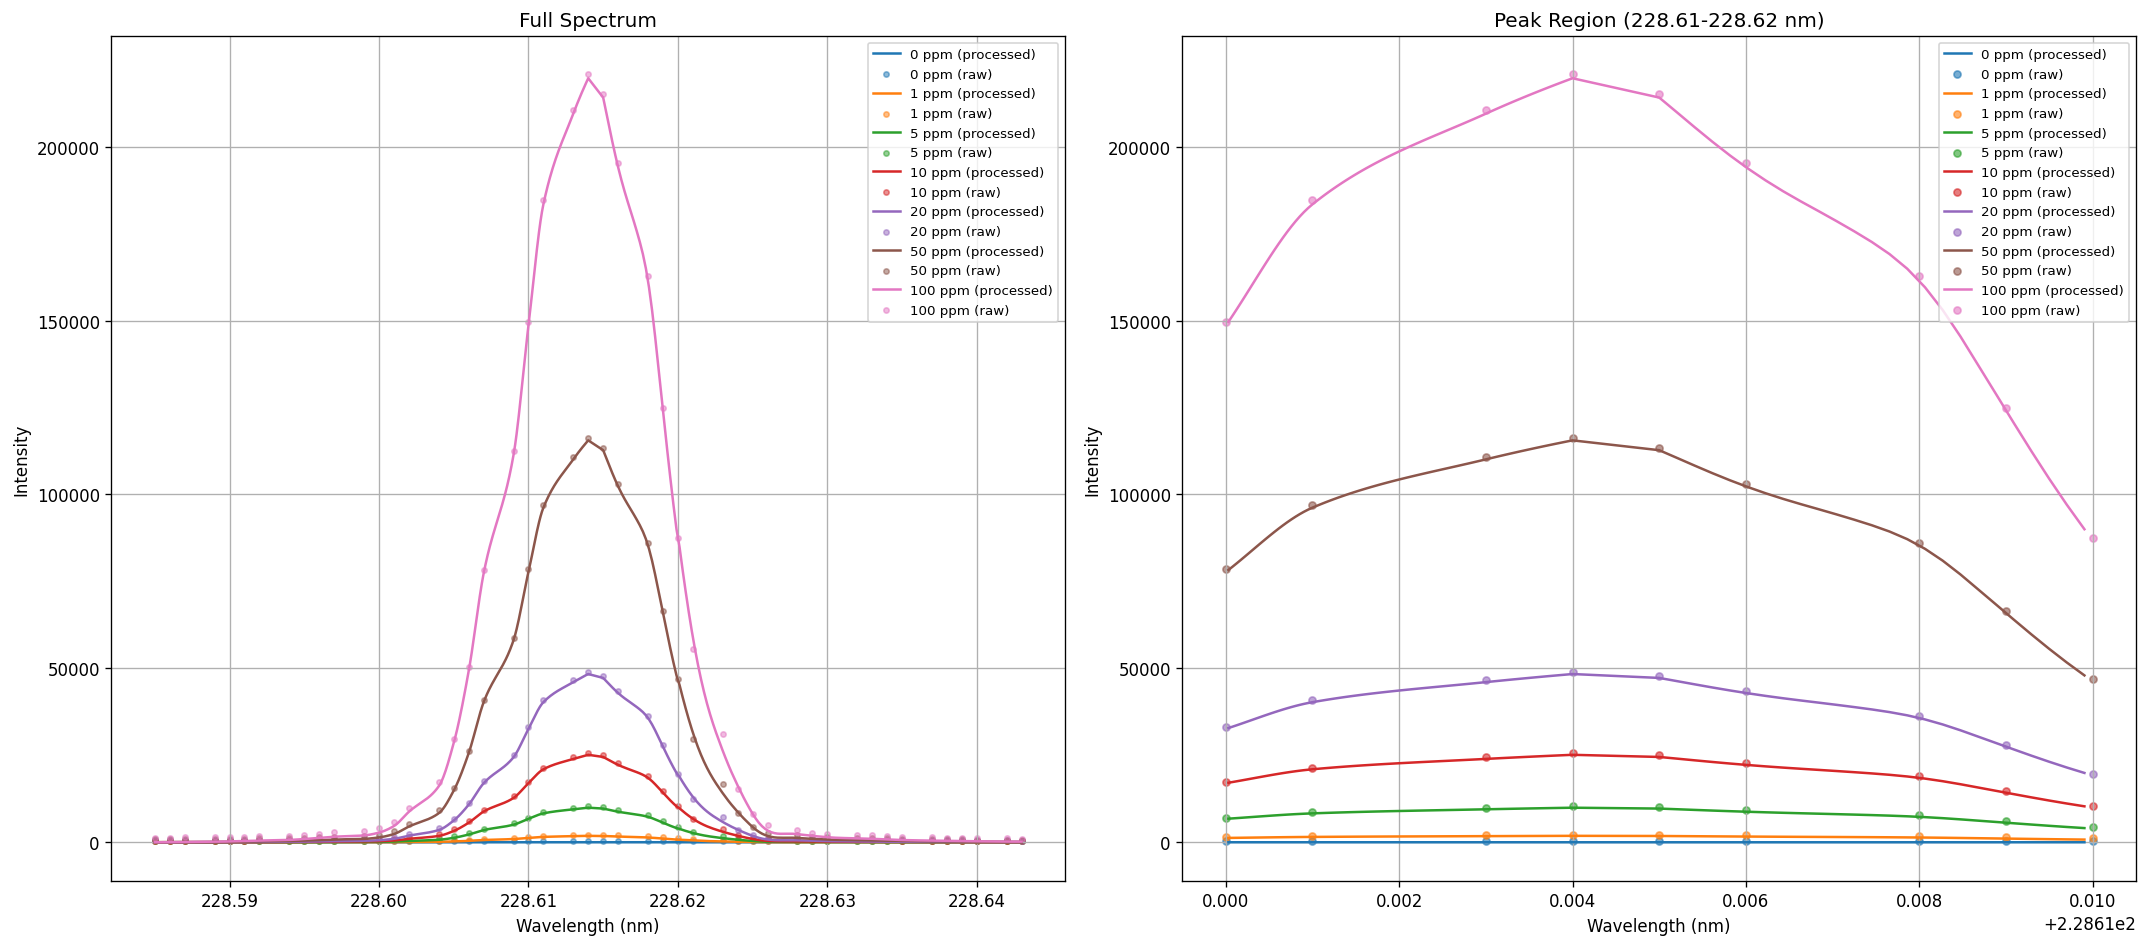

Concentration (ppm)         RMSE  Peak NRMSE  N
0                  0.0   320.979209   33.529636  9
1                  1.0   363.473145    0.327313  9
2                  5.0   374.218809    0.062119  9
3                 10.0   431.703277    0.028360  9
4                 20.0   493.917160    0.016899  9
5                 50.0   709.323027    0.010212  9
6                100.0  1050.349189    0.007884  9

In [20]:
# ------------------------------
# 28) Hibrit parametre araması: sol/sağ için en iyi F, WL, PO, MED (pchip)
# ------------------------------

import numpy as np
import pandas as pd
import time

# Arama uzayları (makul boyut; gerekirse genişletin)
LEFT_WLs = list(range(3, 50, 2))
LEFT_POs = list(range(4, 8))
LEFT_Fs  = list(range(1, 50, 1))
LEFT_MEDs = [None, 3]
LEFT_WL_PEAKS = [None]

RIGHT_WLs = list(range(3, 50, 2))
RIGHT_POs = list(range(4, 8))
RIGHT_Fs  = list(range(1, 50, 1))
RIGHT_MEDs = [None, 3]
RIGHT_WL_PEAKS = [None, 11, 13]

INTERP = 'pchip'

# Split dalgaboyu (tepe λ)
split_wl = _find_split_wavelength_by_peak(co_data, peak_range=PEAK_RANGE, base_params={'interp':INTERP,'F':10,'WL':21,'PO':3,'MED':None})
print(f"Split λ (nm) ≈ {split_wl:.6f}")


def _eval_hybrid(left_params: dict, right_params: dict):
	proc = {}
	for conc in sorted(co_data.keys()):
		proc[conc] = _build_hybrid_for_df(
			co_data[conc],
			split_wl=split_wl,
			peak_range=PEAK_RANGE,
			left_params=left_params,
			right_params=right_params,
		)
	# Toplam kalite (tüm konsantrasyonlar üzerinden)
	rows = []
	total_sq = 0.0
	total_n = 0
	ymin = np.inf
	ymax = -np.inf
	lo, hi = PEAK_RANGE
	for conc, df in sorted(proc.items()):
		x = df['Wavelength'].values
		y = df['Smoothed_Corrected_Spectrum'].values if 'Smoothed_Corrected_Spectrum' in df.columns else df['Spectrum'].values
		raw_x = df.attrs.get('original_wavelength', None)
		raw_y = df.attrs.get('Spectrum_Original', None)
		if raw_x is None or raw_y is None:
			continue
		mask = (raw_x >= lo) & (raw_x <= hi)
		if not np.any(mask):
			continue
		yp = np.interp(raw_x[mask], x, y)
		res = yp - raw_y[mask]
		total_sq += float(np.sum(res**2))
		total_n += int(res.size)
		ymin = min(ymin, float(np.min(raw_y[mask])))
		ymax = max(ymax, float(np.max(raw_y[mask])))
	if total_n == 0:
		return np.nan, np.nan, 0
	rmse = np.sqrt(total_sq / total_n)
	dyn = max(1e-12, ymax - ymin)
	nrmse = rmse / dyn
	return float(nrmse), float(rmse), int(total_n)


# 1) Sağ varsayılan, sol tarafa grid arama (coordinate-descent 1. adım)
right_default = {'interp': INTERP, 'F': 10, 'WL': 31, 'PO': 3, 'MED': 3, 'WL_peak': 13}

best_left = None
best_left_metrics = (np.inf, np.inf, 0)
start = time.time()
count = 0
for wl in LEFT_WLs:
	for po in LEFT_POs:
		for f in LEFT_Fs:
			for med in LEFT_MEDs:
				for wlpk in LEFT_WL_PEAKS:
					left = {'interp': INTERP, 'F': int(f), 'WL': int(wl), 'PO': int(po), 'MED': med, 'WL_peak': wlpk}
					try:
						nrmse, rmse, n = _eval_hybrid(left, right_default)
					except ValueError as e:
						# Eğer pencere boyutu x'in boyutundan büyükse, bu kombinasyonu atla
						if "window_length must be less than or equal to the size of x" in str(e):
							continue
						else:
							raise
					count += 1
					if (nrmse, rmse, -n) < (best_left_metrics[0], best_left_metrics[1], -best_left_metrics[2]):
						best_left = left
						best_left_metrics = (nrmse, rmse, n)
print(f"Sol tarafa arama tamamlandı: {count} kombinasyon, en iyi NRMSE={best_left_metrics[0]*100:.2f}% RMSE={best_left_metrics[1]:.4g} N={best_left_metrics[2]}")

# 2) Sol sabit, sağ tarafa grid arama (coordinate-descent 2. adım)
best_right = None
best_right_metrics = (np.inf, np.inf, 0)
count = 0
for wl in RIGHT_WLs:
	for po in RIGHT_POs:
		for f in RIGHT_Fs:
			for med in RIGHT_MEDs:
				for wlpk in RIGHT_WL_PEAKS:
					right = {'interp': INTERP, 'F': int(f), 'WL': int(wl), 'PO': int(po), 'MED': med, 'WL_peak': wlpk}
					try:
						nrmse, rmse, n = _eval_hybrid(best_left, right)
					except ValueError as e:
						# Eğer pencere boyutu x'in boyutundan büyükse, bu kombinasyonu atla
						if "window_length must be less than or equal to the size of x" in str(e):
							continue
						else:
							raise
					count += 1
					if (nrmse, rmse, -n) < (best_right_metrics[0], best_right_metrics[1], -best_right_metrics[2]):
						best_right = right
						best_right_metrics = (nrmse, rmse, n)
print(f"Sağ tarafa arama tamamlandı: {count} kombinasyon, en iyi NRMSE={best_right_metrics[0]*100:.2f}% RMSE={best_right_metrics[1]:.4g} N={best_right_metrics[2]}")

# 3) Nihai hibrit kalite (sol=best_left, sağ=best_right)
final_nrmse, final_rmse, final_n = _eval_hybrid(best_left, best_right)
print(f"Nihai Hibrit => NRMSE={final_nrmse*100:.2f}% | RMSE={final_rmse:.4g} | N={final_n}")

# 4) Sonuçları rows tarzında raporla
hybrid_rows = []
# Sol için satır (Scenario alanını sol/sağ şeklinde kullanıyoruz)
hybrid_rows.append({
	'Scenario': 'Hybrid-Left-Opt',
	'WL_full': int(best_left['WL']),
	'WL_peak': best_left.get('WL_peak'),
	'PO': int(best_left['PO']),
	'Factor': int(best_left['F']),
	'Interp': best_left['interp'],
	'Peak NRMSE': final_nrmse,
	'RMSE': final_rmse,
	'N': int(final_n),
})
# Sağ için satır
hybrid_rows.append({
	'Scenario': 'Hybrid-Right-Opt',
	'WL_full': int(best_right['WL']),
	'WL_peak': best_right.get('WL_peak'),
	'PO': int(best_right['PO']),
	'Factor': int(best_right['F']),
	'Interp': best_right['interp'],
	'Peak NRMSE': final_nrmse,
	'RMSE': final_rmse,
	'N': int(final_n),
})

hybrid_summary_df = pd.DataFrame(hybrid_rows)
display(hybrid_summary_df)

# 5) Optimal parametrelerle hibrit spektrumları oluştur ve grafik çiz
optimal_hybrid_processed = {}
for conc in sorted(co_data.keys()):
	optimal_hybrid_processed[conc] = _build_hybrid_for_df(
		co_data[conc],
		split_wl=split_wl,
		peak_range=PEAK_RANGE,
		left_params=best_left,
		right_params=best_right,
	)

# Optimal hibrit spektrumları için grafik çiz
print(f"\nOptimal Hibrit Parametreleri:")
print(f"Sol: {best_left}")
print(f"Sağ: {best_right}")
print(f"Split λ: {split_wl:.6f} nm")

plot_processed_spectra(optimal_hybrid_processed, peak_range=PEAK_RANGE)

# Kalite tablosunu da göster
optimal_quality_tbl = _quality(optimal_hybrid_processed)
display(optimal_quality_tbl.sort_values('Concentration (ppm)'))


En iyi senaryo:
  Wiggle (Cubic, WL=3, PO=2, F=21)
  Peak NRMSE=0.277% | RMSE=611.2 | N=63

Tüm sonuçlar (en iyi → en kötü):


Scenario  WL_full  WL_peak  PO  \
0                   Wiggle (Cubic, WL=3, PO=2, F=21)        3      NaN   2   
1  Akima LocalPeak (WL_full=31, WL_peak=11, PO=2,...       31     11.0   2   
2  PCHIP LocalPeak (WL_full=31, WL_peak=13, PO=2,...       31     13.0   2   
3                          PCHIP (WL=15, PO=2, F=10)       15      NaN   2   
4                  Smooth (Cubic, WL=51, PO=3, F=10)       51      NaN   3   

   Factor Interp  Peak NRMSE         RMSE   N  
0      21  cubic    0.002772   611.171362  63  
1      10  akima    0.002838   625.738741  63  
2      10  pchip    0.002933   646.515915  63  
3      10  pchip    0.002978   656.547659  63  
4      10  cubic    0.008650  1907.081372  63


TÜM SENARYOLARIN SPEKTRUMLARI

Wiggle (Cubic, WL=3, PO=2, F=21) için spektrumlar oluşturuluyor...
Wiggle (Cubic, WL=3, PO=2, F=21) grafiği çiziliyor...


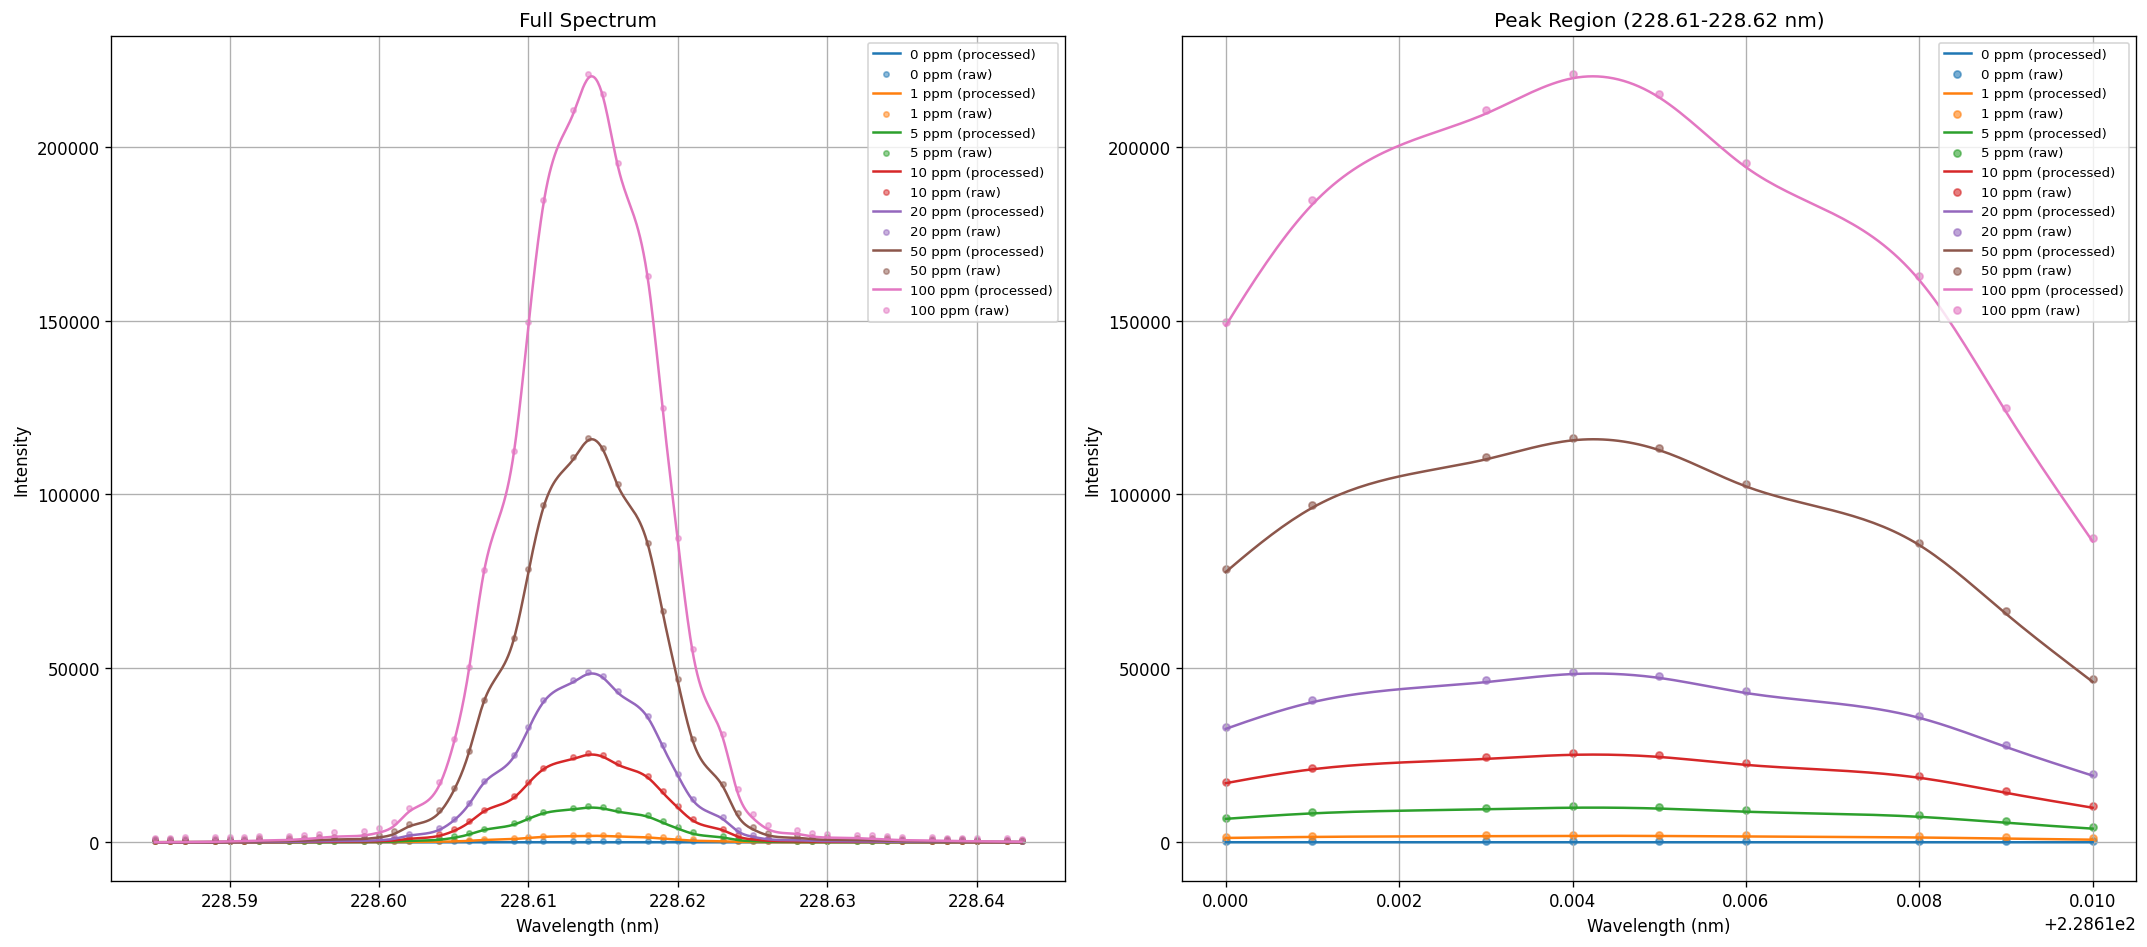


Akima LocalPeak (WL_full=31, WL_peak=11, PO=2, F=10, MED=3) için spektrumlar oluşturuluyor...
Akima LocalPeak (WL_full=31, WL_peak=11, PO=2, F=10, MED=3) grafiği çiziliyor...


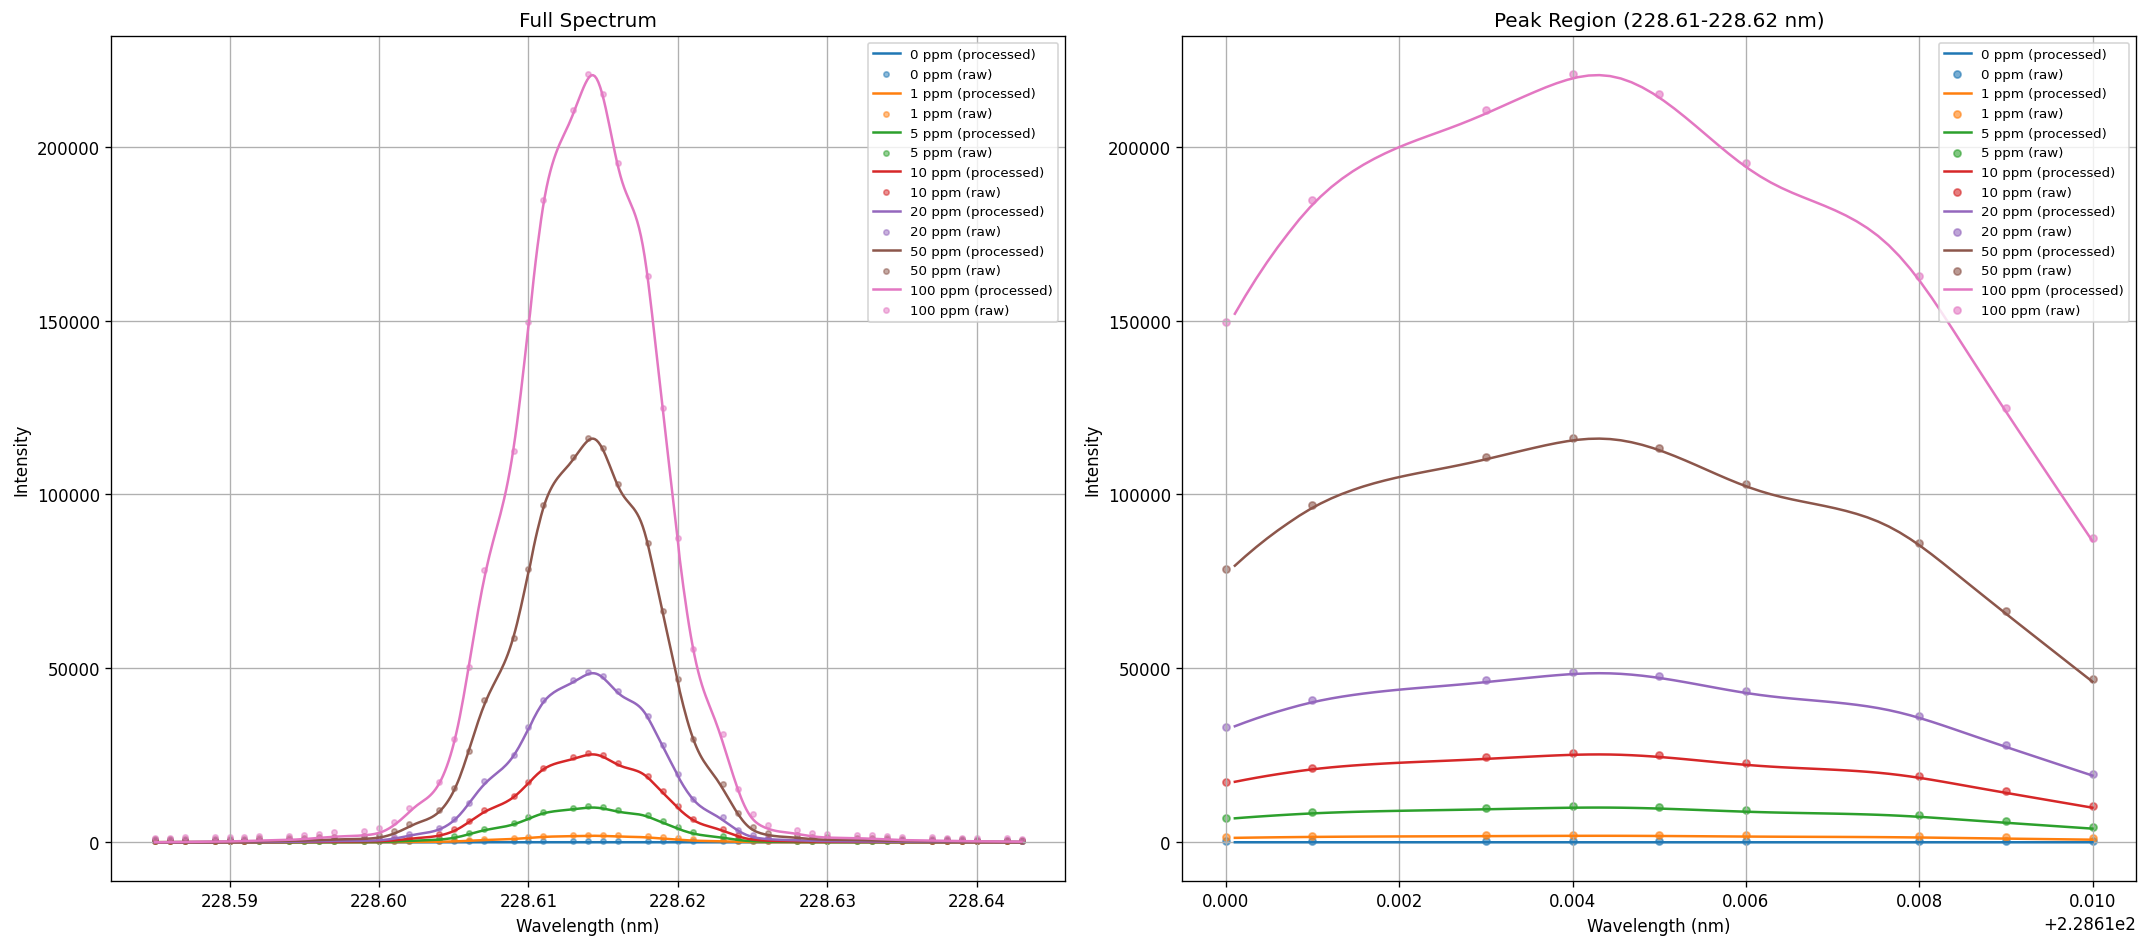


PCHIP LocalPeak (WL_full=31, WL_peak=13, PO=2, F=10, MED=3) için spektrumlar oluşturuluyor...
PCHIP LocalPeak (WL_full=31, WL_peak=13, PO=2, F=10, MED=3) grafiği çiziliyor...


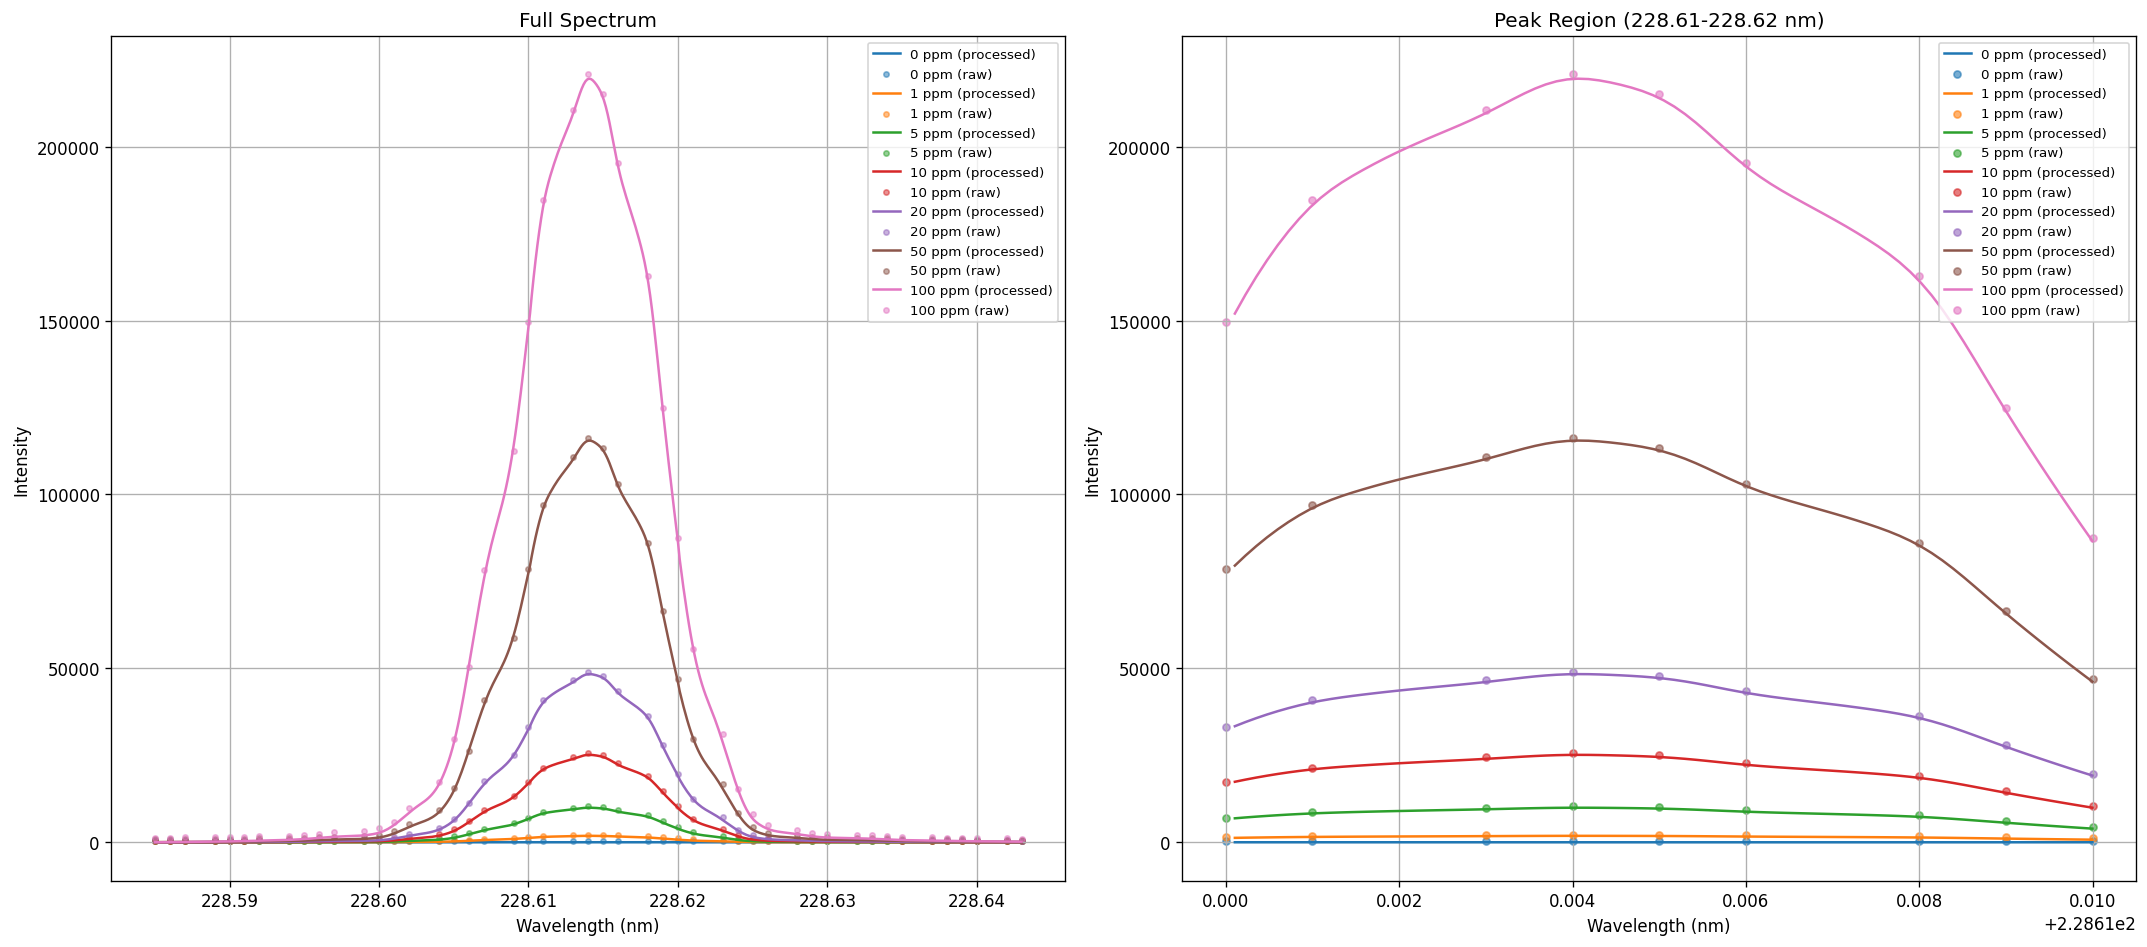


PCHIP (WL=15, PO=2, F=10) için spektrumlar oluşturuluyor...
PCHIP (WL=15, PO=2, F=10) grafiği çiziliyor...


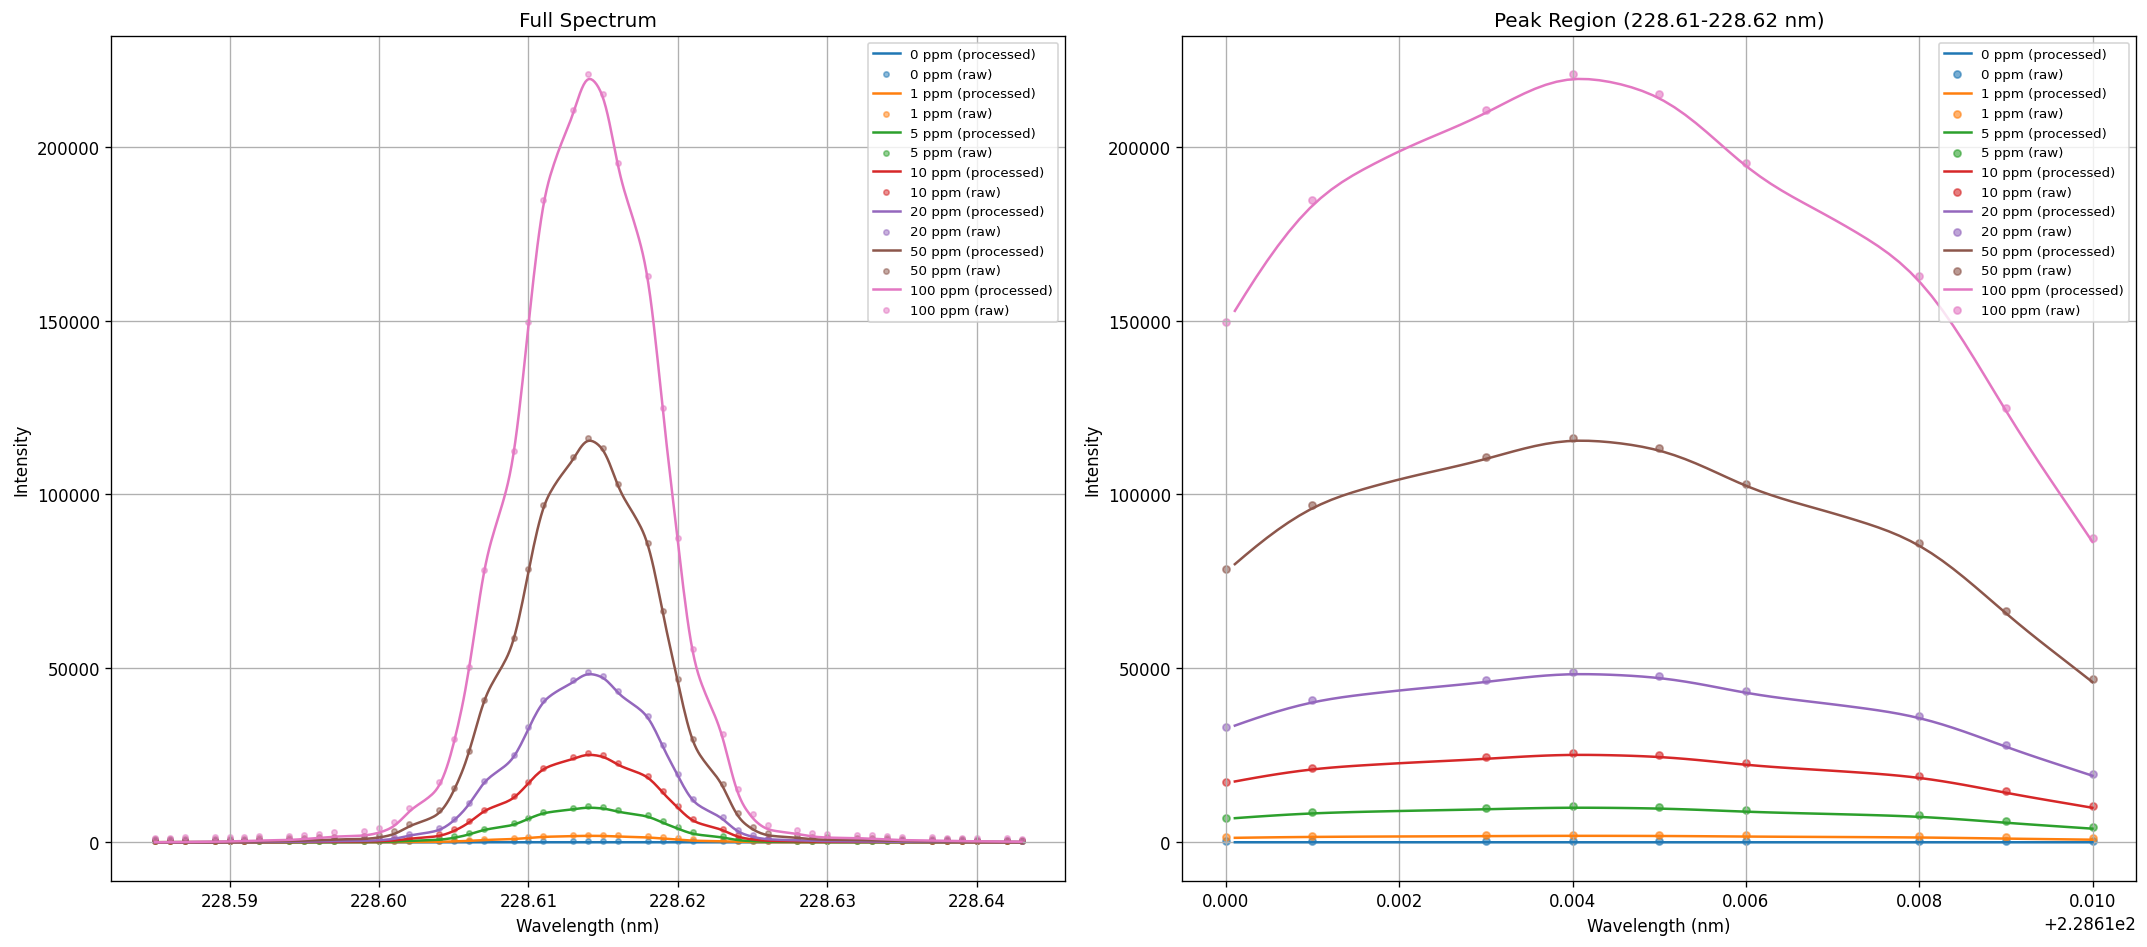


Smooth (Cubic, WL=51, PO=3, F=10) için spektrumlar oluşturuluyor...
Smooth (Cubic, WL=51, PO=3, F=10) grafiği çiziliyor...


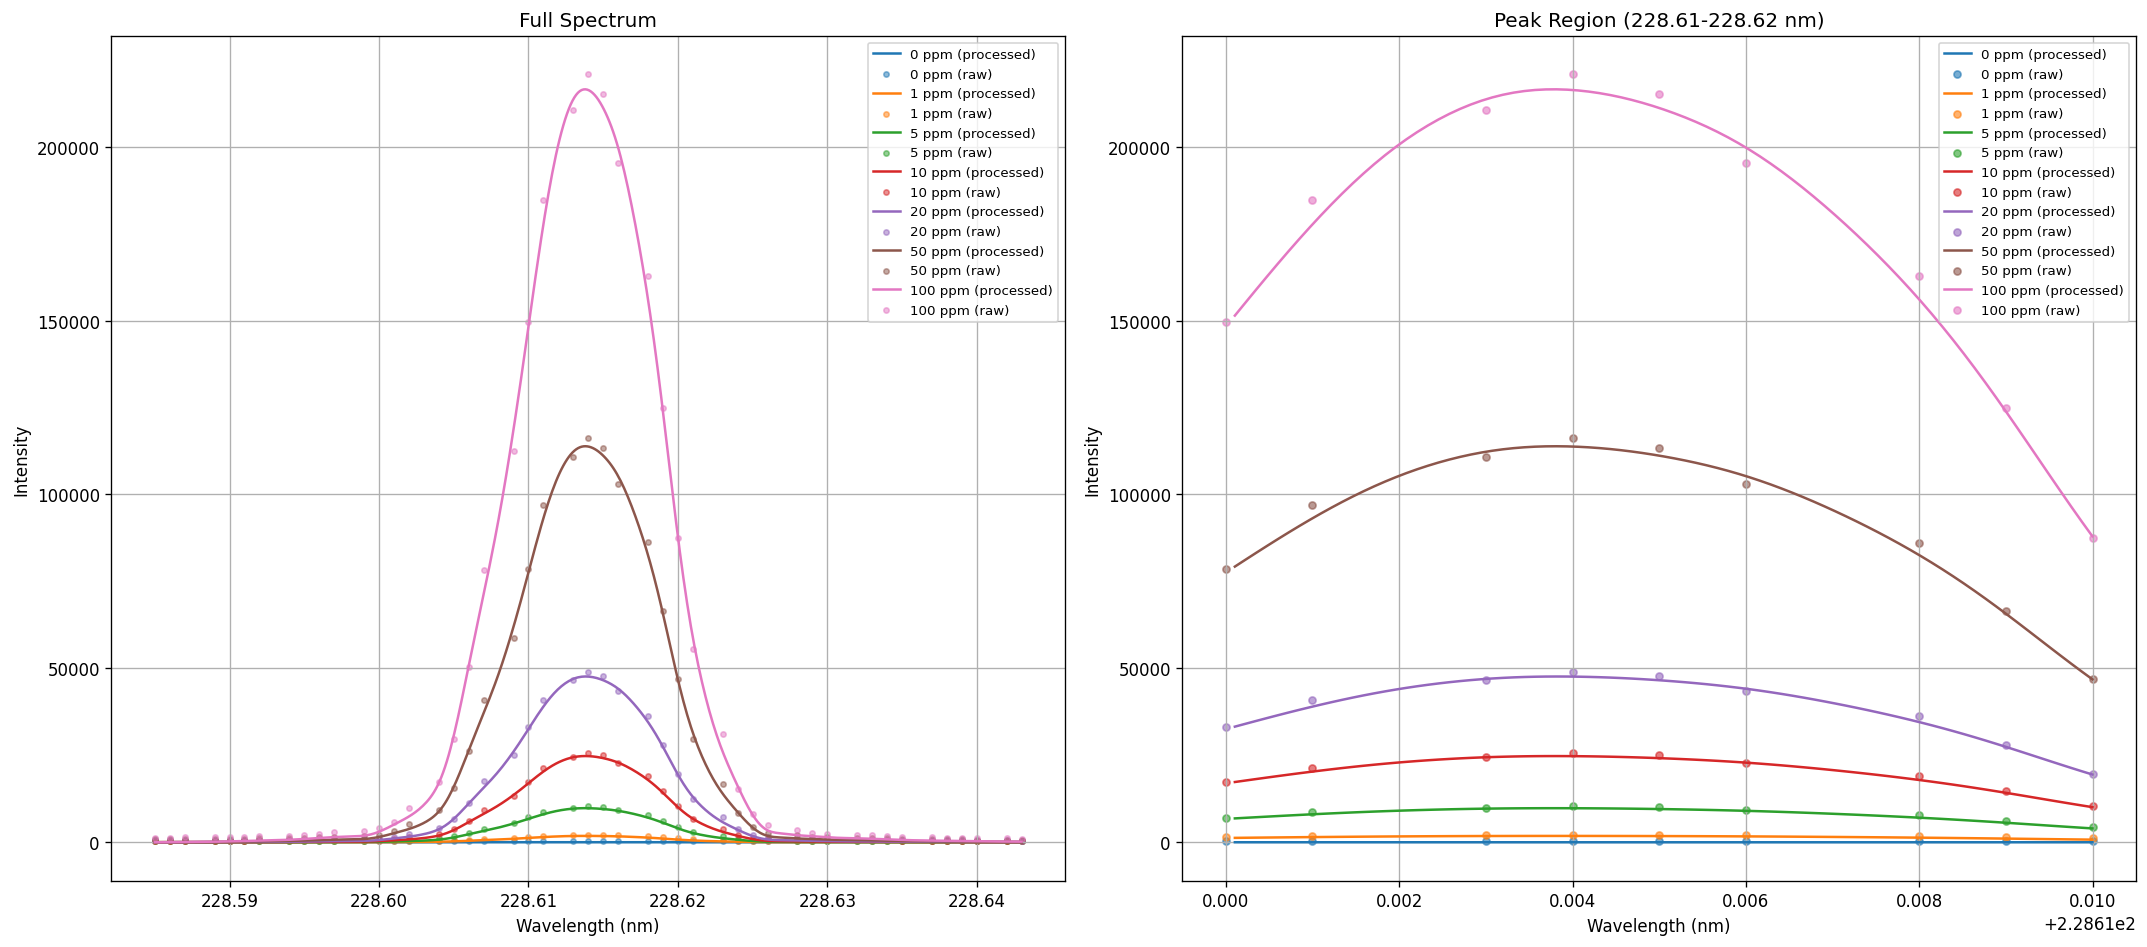


TÜM SENARYOLAR TAMAMLANDI


In [ ]:
# ------------------------------
# 29) Tüm senaryolar + Hibrit karşılaştırması: Peak NRMSE, RMSE, N → en iyiyi seç
# ------------------------------

import numpy as np
import pandas as pd

# 1) Senaryo sonuçlarını al ya da yeniden hesapla (Cell 25 ile uyumlu)
try:
	base_scen_df = summary_df.copy()
except NameError:
	# Cell 25'teki SCENARIOS ve işlem fonksiyonlarına ihtiyaç var
	try:
		_ = process_spectral_data_advanced
		_ = _compute_quality
	except NameError:
		print('Lütfen önce 25. hücreyi çalıştırın (gelişmiş senaryolar).')
		raise SystemExit

	SCENARIOS = [
		{'label': 'Wiggle (Cubic, WL=3, PO=2, F=21)', 'interp': 'cubic', 'F': 21, 'WL_full': 3, 'PO': 2, 'WL_peak': None, 'MED': None},
		{'label': 'Smooth (Cubic, WL=51, PO=3, F=10)', 'interp': 'cubic', 'F': 10, 'WL_full': 51, 'PO': 3, 'WL_peak': None, 'MED': None},
		{'label': 'PCHIP (WL=15, PO=2, F=10)', 'interp': 'pchip', 'F': 10, 'WL_full': 15, 'PO': 2, 'WL_peak': None, 'MED': None},
		{'label': 'PCHIP LocalPeak (WL_full=31, WL_peak=13, PO=2, F=10, MED=3)', 'interp': 'pchip', 'F': 10, 'WL_full': 31, 'PO': 2, 'WL_peak': 13, 'MED': 3},
		{'label': 'Akima LocalPeak (WL_full=31, WL_peak=11, PO=2, F=10, MED=3)', 'interp': 'akima', 'F': 10, 'WL_full': 31, 'PO': 2, 'WL_peak': 11, 'MED': 3},
	]
	rows = []
	for sc in SCENARIOS:
		wl_full = sc['WL_full'] + (1 - sc['WL_full'] % 2)  # tek sayıya zorla
		proc = process_spectral_data_advanced(
			co_data,
			background_subtract=BG_SUBTRACT,
			factor=int(sc['F']),
			interpolation=sc['interp'],
			window_length_full=wl_full,
			polyorder=int(sc['PO']),
			window_length_peak=sc.get('WL_peak'),
			peak_range=PEAK_RANGE,
			pre_median_kernel=sc.get('MED')
		)
		nrmse, rmse, npts = _compute_quality(proc, spectrum_col='Smoothed_Corrected_Spectrum', region=PEAK_RANGE)
		rows.append({'Scenario': sc['label'], 'WL_full': wl_full, 'WL_peak': sc.get('WL_peak'), 'PO': sc['PO'], 'Factor': sc['F'], 'Interp': sc['interp'], 'Peak NRMSE': nrmse, 'RMSE': rmse, 'N': npts})
	base_scen_df = pd.DataFrame(rows)

# 2) Hibrit (Cell 28) en iyi sol/sağ ile metrikleri ekle

def _aggregate_quality(proc_dict):
	# Cell 25'teki _compute_quality ile aynı mantık; oraya fallback
	try:
		return _compute_quality(proc_dict, spectrum_col='Smoothed_Corrected_Spectrum', region=PEAK_RANGE)
	except Exception:
		lo, hi = PEAK_RANGE
		total_sq = 0.0
		total_n = 0
		ymin, ymax = np.inf, -np.inf
		for _, df in sorted(proc_dict.items()):
			x = df['Wavelength'].values
			y = df['Smoothed_Corrected_Spectrum'].values if 'Smoothed_Corrected_Spectrum' in df.columns else df['Spectrum'].values
			raw_x = df.attrs.get('original_wavelength', None)
			raw_y = df.attrs.get('Spectrum_Original', None)
			if raw_x is None or raw_y is None:
				continue
			mask = (raw_x >= lo) & (raw_x <= hi)
			if not np.any(mask):
				continue
			yp = np.interp(raw_x[mask], x, y)
			res = yp - raw_y[mask]
			total_sq += float(np.sum(res**2))
			total_n += int(res.size)
			ymin = min(ymin, float(np.min(raw_y[mask])))
			ymax = max(ymax, float(np.max(raw_y[mask])))
		if total_n == 0:
			return np.nan, np.nan, 0
		rmse = np.sqrt(total_sq / total_n)
		dyn = max(1e-12, ymax - ymin)
		nrmse = rmse / dyn
		return float(nrmse), float(rmse), int(total_n)

hybrid_row = None
try:
	# Tercihen Cell 28'deki en iyi sol/sağı kullan
	_ = best_left; _ = best_right
	try:
		# Cell 28 fonksiyonu
		nrmse, rmse, n = _eval_hybrid(best_left, best_right)
		hybrid_row = {'Scenario': 'Hybrid-Opt', 'WL_full': None, 'WL_peak': None, 'PO': None, 'Factor': None, 'Interp': 'pchip', 'Peak NRMSE': nrmse, 'RMSE': rmse, 'N': n}
	except NameError:
		# Cell 27'deki kurulu hibrit veri varsa onu topla
		try:
			_ = hybrid_processed
			nrmse, rmse, n = _aggregate_quality(hybrid_processed)
			hybrid_row = {'Scenario': 'Hybrid-Opt', 'WL_full': None, 'WL_peak': None, 'PO': None, 'Factor': None, 'Interp': 'pchip', 'Peak NRMSE': nrmse, 'RMSE': rmse, 'N': n}
		except NameError:
			# best_left/right ile doğrudan yeniden üret
			proc = {}
			for conc in sorted(co_data.keys()):
				proc[conc] = _build_hybrid_for_df(co_data[conc], split_wl=_find_split_wavelength_by_peak(co_data, PEAK_RANGE), peak_range=PEAK_RANGE, left_params=best_left, right_params=best_right)
			nrmse, rmse, n = _aggregate_quality(proc)
			hybrid_row = {'Scenario': 'Hybrid-Opt', 'WL_full': None, 'WL_peak': None, 'PO': None, 'Factor': None, 'Interp': 'pchip', 'Peak NRMSE': nrmse, 'RMSE': rmse, 'N': n}
except NameError:
	# Hibrit mevcut değilse geç
	pass

# 3) Birleştir, sırala ve en iyiyi seç
cols = ['Scenario', 'WL_full', 'WL_peak', 'PO', 'Factor', 'Interp', 'Peak NRMSE', 'RMSE', 'N']
combined = base_scen_df.copy()
if hybrid_row is not None:
	combined = pd.concat([combined, pd.DataFrame([hybrid_row])], ignore_index=True)

combined_valid = combined.dropna(subset=['Peak NRMSE', 'RMSE']).copy()
if len(combined_valid) == 0:
	print('Karşılaştırma için geçerli sonuç yok.')
else:
	best = combined_valid.sort_values(['Peak NRMSE', 'RMSE', 'N'], ascending=[True, True, False]).iloc[0]
	print('En iyi senaryo:')
	print(f"  {best['Scenario']}")
	print(f"  Peak NRMSE={best['Peak NRMSE']*100:.3f}% | RMSE={best['RMSE']:.4g} | N={int(best['N'])}")
	print('\nTüm sonuçlar (en iyi → en kötü):')
	display(combined_valid.sort_values(['Peak NRMSE', 'RMSE', 'N'], ascending=[True, True, False]).reset_index(drop=True)[cols])

# 4) Tüm senaryoların spektrumlarını oluştur ve grafik çiz
print('\n' + '='*80)
print('TÜM SENARYOLARIN SPEKTRUMLARI')
print('='*80)

# Tüm senaryoların işlenmiş spektrumlarını sakla
all_scenario_spectra = {}

# Base senaryolar için spektrumları oluştur
for idx, row in base_scen_df.iterrows():
	scenario_name = row['Scenario']
	print(f"\n{scenario_name} için spektrumlar oluşturuluyor...")
	
	# Senaryo parametrelerini bul
	scenario_params = None
	for sc in SCENARIOS:
		if sc['label'] == scenario_name:
			scenario_params = sc
			break
	
	if scenario_params is not None:
		wl_full = scenario_params['WL_full'] + (1 - scenario_params['WL_full'] % 2)
		processed_spectra = process_spectral_data_advanced(
			co_data,
			background_subtract=BG_SUBTRACT,
			factor=int(scenario_params['F']),
			interpolation=scenario_params['interp'],
			window_length_full=wl_full,
			polyorder=int(scenario_params['PO']),
			window_length_peak=scenario_params.get('WL_peak'),
			peak_range=PEAK_RANGE,
			pre_median_kernel=scenario_params.get('MED')
		)
		all_scenario_spectra[scenario_name] = processed_spectra
		
		# Her senaryo için grafik çiz
		print(f"{scenario_name} grafiği çiziliyor...")
		plot_processed_spectra(processed_spectra, peak_range=PEAK_RANGE)

# Hibrit senaryo için spektrum oluştur ve grafik çiz
if hybrid_row is not None:
	print(f"\nHybrid-Opt için spektrumlar oluşturuluyor...")
	try:
		# En iyi hibrit parametrelerle spektrumları oluştur
		hybrid_spectra = {}
		for conc in sorted(co_data.keys()):
			hybrid_spectra[conc] = _build_hybrid_for_df(
				co_data[conc],
				split_wl=_find_split_wavelength_by_peak(co_data, PEAK_RANGE),
				peak_range=PEAK_RANGE,
				left_params=best_left,
				right_params=best_right,
			)
		all_scenario_spectra['Hybrid-Opt'] = hybrid_spectra
		
		print("Hybrid-Opt grafiği çiziliyor...")
		plot_processed_spectra(hybrid_spectra, peak_range=PEAK_RANGE)
		
	except Exception as e:
		print(f"Hibrit spektrum oluşturulurken hata: {e}")

print('\n' + '='*80)
print('TÜM SENARYOLAR TAMAMLANDI')
print('='*80)


Peak λ ≈ 228.614186 | Right-neighbor λ ≈ 228.615000
Toplam kombinasyon sayısı: 1456
Kombinasyon 1/1456 test ediliyor...
Kombinasyon 2/1456 test ediliyor...
Kombinasyon 3/1456 test ediliyor...
Kombinasyon 4/1456 test ediliyor...
Kombinasyon 5/1456 test ediliyor...
Kombinasyon 6/1456 test ediliyor...
Kombinasyon 7/1456 test ediliyor...
Kombinasyon 8/1456 test ediliyor...
Kombinasyon 9/1456 test ediliyor...
Kombinasyon 10/1456 test ediliyor...
Kombinasyon 11/1456 test ediliyor...
Kombinasyon 12/1456 test ediliyor...
Kombinasyon 13/1456 test ediliyor...
Kombinasyon 14/1456 test ediliyor...
Kombinasyon 15/1456 test ediliyor...
Kombinasyon 16/1456 test ediliyor...
Kombinasyon 17/1456 test ediliyor...
Kombinasyon 18/1456 test ediliyor...
Kombinasyon 19/1456 test ediliyor...
Kombinasyon 20/1456 test ediliyor...
Kombinasyon 21/1456 test ediliyor...
Kombinasyon 22/1456 test ediliyor...
Kombinasyon 23/1456 test ediliyor...
Kombinasyon 24/1456 test ediliyor...
Kombinasyon 25/1456 test ediliyor...


Scenario  WL_full  WL_peak  PO  Factor Interp  Peak NRMSE  \
0   Hybrid-3Seg-Left        5      NaN   4      25  pchip    0.002672   
1    Hybrid-3Seg-Mid        3      NaN   1       1  akima    0.002672   
2  Hybrid-3Seg-Right       47     13.0   4       6  pchip    0.002672   

         RMSE   N  
0  588.978363  63  
1  588.978363  63  
2  588.978363  63

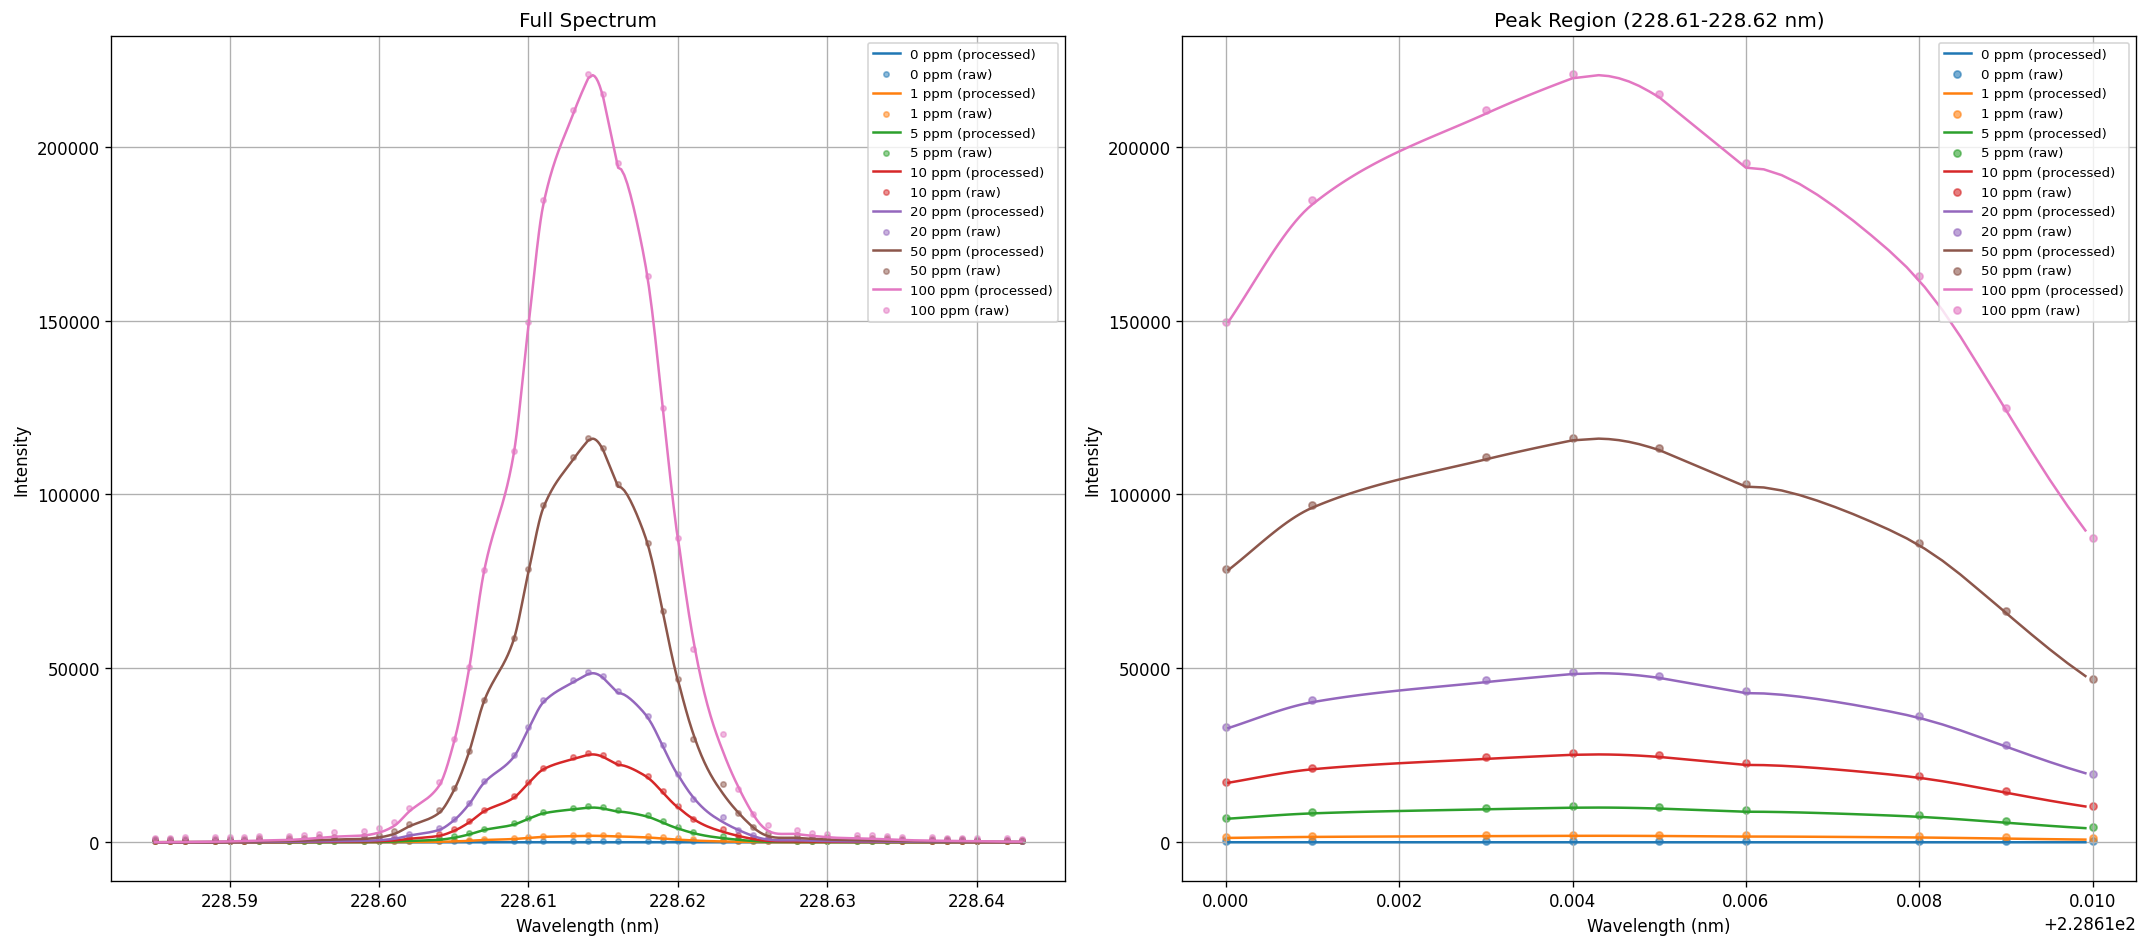

In [23]:
# ------------------------------
# 3-segment hibrit: TepeÖncesi | (Tepe→Sonraki) | GeriKalan
#     Orta segment (Tepe→Sonraki) için grid arama ile en iyi WL/PO/F/MED
# ------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sağlam komşu bulucu: en yüksek konsantrasyonun ham dalgaboylarından tepenin sağ komşusunu bul
# Eğer bulunamazsa (tepe en sağdaysa) peak_wl + epsilon döner
def _find_right_neighbor_from_raw(co_data: dict, peak_wl: float) -> float:
	conc_max = max(co_data.keys())
	raw_x = co_data[conc_max]['Wavelength'].values
	# Sıralı varsayılır; değilse sırala
	if not np.all(np.diff(raw_x) >= 0):
		raw_x = np.sort(raw_x)
	idx = np.searchsorted(raw_x, peak_wl, side='right')
	if idx < len(raw_x):
		return float(raw_x[idx])
	return float(peak_wl + 1e-6)

# Tek DataFrame için 3-segment hibrit oluştur
# left_params/mid_params/right_params: {'interp','F','WL','PO','MED','WL_peak'(ops)}
def _build_triple_hybrid_for_df(df: pd.DataFrame,
								 peak_wl: float,
								 neighbor_wl: float,
								 peak_range=PEAK_RANGE,
								 left_params: dict | None = None,
								 mid_params: dict | None = None,
								 right_params: dict | None = None) -> pd.DataFrame:
	cur = df.copy()
	if 'Background' in cur.columns and 'Corrected_Spectrum' not in cur.columns:
		cur['Corrected_Spectrum'] = cur['Spectrum'] - cur['Background']
	if 'Spectrum_Original' not in cur.columns:
		cur['Spectrum_Original'] = cur['Spectrum']

	# Segmentler (ham ızgaraya göre)
	left_org = cur[cur['Wavelength'] <= peak_wl]
	mid_org = cur[(cur['Wavelength'] > peak_wl) & (cur['Wavelength'] <= neighbor_wl)]
	right_org = cur[cur['Wavelength'] > neighbor_wl]

	# Varsayılan parametreler
	L = left_params or {'interp':'pchip','F':12,'WL':13,'PO':2,'MED':3,'WL_peak':None}
	M = mid_params or {'interp':'pchip','F':10,'WL':9,'PO':2,'MED':3,'WL_peak':None}
	R = right_params or {'interp':'pchip','F':10,'WL':31,'PO':3,'MED':3,'WL_peak':13}

	def _segment_process(seg_df, P, seg_min_x=None, seg_max_x=None, full_df=None):
		if len(seg_df) == 0:
			# Eğer aralık çok darsa, full_df üzerinden küçük bir bantta örnekleme yap
			if full_df is not None and (seg_min_x is not None) and (seg_max_x is not None):
				x_full = full_df['Wavelength'].values.astype(float)
				y_base_col = 'Corrected_Spectrum' if 'Corrected_Spectrum' in full_df.columns else 'Spectrum'
				y_full = full_df[y_base_col].values.astype(float)
				# interpolatör seçimi
				if P['interp'] == 'pchip':
					f = interp.PchipInterpolator(x_full, y_full)
				elif P['interp'] == 'akima':
					f = interp.Akima1DInterpolator(x_full, y_full)
				else:
					f = interp.CubicSpline(x_full, y_full)
				n_pts = max(8, int(P.get('F', 10)) * 3)
				x_new = np.linspace(seg_min_x, seg_max_x, n_pts)
				y_new = f(x_new)
				# Küçük pencerede SG ile hafif düzeltme
				from scipy.signal import savgol_filter
				wl_eff = P['WL'] if P['WL'] % 2 == 1 else P['WL'] + 1
				wl_eff = min(wl_eff, len(x_new) - (1 - (len(x_new) % 2))) if len(x_new) > 3 else 3
				if wl_eff % 2 == 0:
					wl_eff = max(3, wl_eff - 1)
				y_new = savgol_filter(y_new, wl_eff, min(int(P['PO']), wl_eff - 1)) if len(x_new) >= wl_eff else y_new
				return x_new, y_new
			return np.array([]), np.array([])
		# Len < 2: komşu bantta full_df ile örnekleme yap
		if len(seg_df) < 2 and full_df is not None and (seg_min_x is not None) and (seg_max_x is not None):
			x_full = full_df['Wavelength'].values.astype(float)
			y_base_col = 'Corrected_Spectrum' if 'Corrected_Spectrum' in full_df.columns else 'Spectrum'
			y_full = full_df[y_base_col].values.astype(float)
			if P['interp'] == 'pchip':
				f = interp.PchipInterpolator(x_full, y_full)
			elif P['interp'] == 'akima':
				f = interp.Akima1DInterpolator(x_full, y_full)
			else:
				f = interp.CubicSpline(x_full, y_full)
			n_pts = max(8, int(P.get('F', 10)) * 3)
			x_new = np.linspace(seg_min_x, seg_max_x, n_pts)
			y_new = f(x_new)
			from scipy.signal import savgol_filter
			wl_eff = P['WL'] if P['WL'] % 2 == 1 else P['WL'] + 1
			wl_eff = min(wl_eff, len(x_new) - (1 - (len(x_new) % 2))) if len(x_new) > 3 else 3
			if wl_eff % 2 == 0:
				wl_eff = max(3, wl_eff - 1)
			y_new = savgol_filter(y_new, wl_eff, min(int(P['PO']), wl_eff - 1)) if len(x_new) >= wl_eff else y_new
			return x_new, y_new
		# Normal yol
		wl = P['WL'] if P['WL'] % 2 == 1 else P['WL'] + 1
		hi = increase_data_points_adv(seg_df, factor=int(P['F']), method=P['interp'])
		sm = apply_sg_smoothing_adv(
			hi,
			window_length_full=wl,
			polyorder=int(P['PO']),
			window_length_peak=P.get('WL_peak'),
			peak_range=peak_range,
			pre_median_kernel=P.get('MED')
		)
		for c in ['Smoothed_Corrected_Spectrum','Smoothed_Interpolated_Spectrum','Interpolated_Corrected_Spectrum','Corrected_Spectrum','Interpolated_Spectrum','Spectrum']:
			if c in sm.columns:
				return sm['Wavelength'].values, sm[c].values
		return sm['Wavelength'].values, sm['Spectrum'].values

	xL, yL = _segment_process(left_org, L)
	xM, yM = _segment_process(mid_org, M, seg_min_x=peak_wl, seg_max_x=neighbor_wl, full_df=cur)
	xR, yR = _segment_process(right_org, R)

	# Birleştir ve sırala (sınır tekrarlı noktaları kırp)
	parts_x = []
	parts_y = []
	if len(xL):
		maskL = xL <= peak_wl
		parts_x.append(xL[maskL])
		parts_y.append(yL[maskL])
	if len(xM):
		maskM = (xM > peak_wl) & (xM <= neighbor_wl)
		parts_x.append(xM[maskM])
		parts_y.append(yM[maskM])
	if len(xR):
		maskR = xR > neighbor_wl
		parts_x.append(xR[maskR])
		parts_y.append(yR[maskR])
	if len(parts_x) == 0:
		return pd.DataFrame({'Wavelength': np.array([]), 'Smoothed_Corrected_Spectrum': np.array([])})
	xH = np.concatenate(parts_x)
	yH = np.concatenate(parts_y)
	ord = np.argsort(xH)
	xH, yH = xH[ord], yH[ord]
	# Tekillikleri kaldır
	if len(xH) > 1:
		uniq_idx = np.concatenate([[0], np.where(np.diff(xH) > 0)[0] + 1])
		xH, yH = xH[uniq_idx], yH[uniq_idx]

	out = pd.DataFrame({'Wavelength': xH, 'Smoothed_Corrected_Spectrum': yH})
	# attrs ile ham referansları sakla
	out['Spectrum_Original'] = np.nan
	out.attrs['original_wavelength'] = cur['Wavelength'].values
	out.attrs['Spectrum_Original'] = cur['Spectrum_Original'].values
	return out

	out = pd.DataFrame({'Wavelength': xH, 'Smoothed_Corrected_Spectrum': yH})
	out['Spectrum_Original'] = np.nan
	out.attrs['original_wavelength'] = cur['Wavelength'].values
	out.attrs['Spectrum_Original'] = cur['Spectrum_Original'].values
	return out

# Toplam kalite (Peak Region): NRMSE, RMSE, N

def _quality_aggregate(proc_dict: dict, region=PEAK_RANGE):
	lo, hi = region
	total_sq, total_n = 0.0, 0
	ymin, ymax = np.inf, -np.inf
	for _, df in sorted(proc_dict.items()):
		x = df['Wavelength'].values
		y = df['Smoothed_Corrected_Spectrum'].values if 'Smoothed_Corrected_Spectrum' in df.columns else df['Spectrum'].values
		raw_x = df.attrs.get('original_wavelength', None)
		raw_y = df.attrs.get('Spectrum_Original', None)
		if raw_x is None or raw_y is None:
			continue
		mask = (raw_x >= lo) & (raw_x <= hi)
		if not np.any(mask):
			continue
		yp = np.interp(raw_x[mask], x, y)
		res = yp - raw_y[mask]
		total_sq += float(np.sum(res**2))
		total_n += int(res.size)
		ymin = min(ymin, float(np.min(raw_y[mask])))
		ymax = max(ymax, float(np.max(raw_y[mask])))
	if total_n == 0:
		return np.nan, np.nan, 0
	rmse = np.sqrt(total_sq / total_n)
	dyn = max(1e-12, ymax - ymin)
	nrmse = rmse / dyn
	return float(nrmse), float(rmse), int(total_n)

# 1) Tepe ve sağ komşu λ belirle
peak_wl = _find_split_wavelength_by_peak(co_data, peak_range=PEAK_RANGE, base_params={'interp':'pchip','F':10,'WL':21,'PO':3,'MED':None})
neighbor_wl = _find_right_neighbor_from_raw(co_data, peak_wl)
print(f"Peak λ ≈ {peak_wl:.6f} | Right-neighbor λ ≈ {neighbor_wl:.6f}")

# 2) Sol/sağ parametreleri (Cell 28 sonuçları varsa onları kullan)
try:
	LBASE = best_left.copy()
	RBASE = best_right.copy()
except NameError:
	LBASE = {'interp':'pchip','F':12,'WL':13,'PO':2,'MED':3,'WL_peak':None}
	RBASE = {'interp':'pchip','F':10,'WL':31,'PO':3,'MED':3,'WL_peak':13}

# 3) Orta segment (Tepe→Sonraki) için grid arama
MID_WLs = list(range(3, 4, 2))
MID_POs = list(range(1, 8))
MID_Fs = list(range(1, 53, 1))
MID_MEDs = [None, 3]
MID_INTERPS = ['pchip', 'akima']

# Toplam kombinasyon sayısını hesapla
total_combinations = len(MID_WLs) * len(MID_POs) * len(MID_Fs) * len(MID_MEDs) * len(MID_INTERPS)
print(f"Toplam kombinasyon sayısı: {total_combinations}")

best_mid = None
best_metrics = (np.inf, np.inf, 0)
triple_rows = []
current_combination = 0

for wl in MID_WLs:
	for po in MID_POs:
		for f in MID_Fs:
			for med in MID_MEDs:
				for itp in MID_INTERPS:
					current_combination += 1
					print(f"Kombinasyon {current_combination}/{total_combinations} test ediliyor...")
					
					MTRY = {'interp': itp, 'F': int(f), 'WL': int(wl), 'PO': int(po), 'MED': med, 'WL_peak': None}
					# Tüm konsantrasyonlar için triple hibrit kur ve kaliteyi ölç
					proc = {}
					for conc in sorted(co_data.keys()):
						proc[conc] = _build_triple_hybrid_for_df(
							co_data[conc],
							peak_wl=peak_wl,
							neighbor_wl=neighbor_wl,
							peak_range=PEAK_RANGE,
							left_params=LBASE,
							mid_params=MTRY,
							right_params=RBASE,
						)
					nrmse, rmse, n = _quality_aggregate(proc)
					if (nrmse, rmse, -n) < (best_metrics[0], best_metrics[1], -best_metrics[2]):
						best_mid = MTRY
						best_metrics = (nrmse, rmse, n)

print(f"En iyi ORTA (Tepe→Sonraki): interp={best_mid['interp']} WL={best_mid['WL']} PO={best_mid['PO']} F={best_mid['F']} MED={best_mid['MED']} | NRMSE={best_metrics[0]*100:.2f}% RMSE={best_metrics[1]:.4g} N={best_metrics[2]}")

# 4) Nihai 3-segment hibrit ile çiz ve rows ekle
final_proc = {}
for conc in sorted(co_data.keys()):
	final_proc[conc] = _build_triple_hybrid_for_df(
		co_data[conc],
		peak_wl=peak_wl,
		neighbor_wl=neighbor_wl,
		peak_range=PEAK_RANGE,
		left_params=LBASE,
		mid_params=best_mid,
		right_params=RBASE,
	)

final_nrmse, final_rmse, final_n = _quality_aggregate(final_proc)
print(f"Nihai 3-seg Hibrit => NRMSE={final_nrmse*100:.2f}% | RMSE={final_rmse:.4g} | N={final_n}")

# rows tarzı rapor (üç satır)
triple_rows.append({'Scenario': 'Hybrid-3Seg-Left', 'WL_full': int(LBASE['WL']), 'WL_peak': LBASE.get('WL_peak'), 'PO': int(LBASE['PO']), 'Factor': int(LBASE['F']), 'Interp': LBASE['interp'], 'Peak NRMSE': final_nrmse, 'RMSE': final_rmse, 'N': int(final_n)})
triple_rows.append({'Scenario': 'Hybrid-3Seg-Mid',  'WL_full': int(best_mid['WL']), 'WL_peak': best_mid.get('WL_peak'), 'PO': int(best_mid['PO']), 'Factor': int(best_mid['F']), 'Interp': best_mid['interp'], 'Peak NRMSE': final_nrmse, 'RMSE': final_rmse, 'N': int(final_n)})
triple_rows.append({'Scenario': 'Hybrid-3Seg-Right','WL_full': int(RBASE['WL']), 'WL_peak': RBASE.get('WL_peak'), 'PO': int(RBASE['PO']), 'Factor': int(RBASE['F']), 'Interp': RBASE['interp'], 'Peak NRMSE': final_nrmse, 'RMSE': final_rmse, 'N': int(final_n)})

triple_df = pd.DataFrame(triple_rows)
display(triple_df)

# Görselleştirme
plot_processed_spectra(final_proc, peak_range=PEAK_RANGE)


Son olarak,

Her ne kadar grafiğe bakarak çeşitli kısımlara bölerek o bölümler için ayrı ayrı grid araması çalıştırsak da, bu pipeline'ı bu şekilde değil, her türlü verinin gelebileceği olasılığına karşılık dinamik olarak sistemin kendisinin otomatik ayarlamasını istememiz daha mantıklı bir istek olacaktır. Ayrıca buradaki grid aramasında Python işlemci çekirdeklerini tam olarak kullanmaz (belki multiprocessing veya joblib ile çözülebilirdi) ve 1 saate çıkan işlem süreleriyle karşılaşırız (burada Ryzen 7 6800H işlemci kullanıldı, RyzenAdj ile hız aşırtıldı). 

Bu ve performans sorunlarına karşılık, işi Python'dan çekip C++ ile CUDA kütüphanesi yardımıyla yükü nVidia markalı GPU'lara vererek 20-30 kat daha da hızlandırabiliriz.

Sonraki çalışmada buradaki kodun daha optimize edilmiş, grid aramalarının tepe noktalarına göre değil, her veri setine göre ayrı ve özgün olarak ayarlanmış, işlemci yerine bu iş için optimize edilmiş GPU çekirdeklerinin kullanıldığı CUDA kütüphanesi destekli bir pipeline yazılabilir.